# Non Temporal Trends - Part1

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
# load data_4072.json to pandas dataframe
df = pd.read_json('data_4072.json', orient='records')

# overall analysis
df['Average ⬆️'] = pd.to_numeric(df['Average ⬆️'], errors='coerce')
df['CO₂ cost (kg)'] = pd.to_numeric(df['CO₂ cost (kg)'], errors='coerce')
df['#Params (B)'] = pd.to_numeric(df['#Params (B)'], errors='coerce')

highest_avg_row = df.loc[df['Average ⬆️'].idxmax()]
lowest_co2_row = df.loc[df['CO₂ cost (kg)'].idxmin()]
lowest_params_row = df.loc[df['#Params (B)'].idxmin()]

df_eff = df[(df['CO₂ cost (kg)'] != 0) & (df['#Params (B)'] != 0) & (df['#Params (B)'] != -1)]

df_eff = df_eff.copy() 
df_eff['carbon_efficiency'] = df_eff['Average ⬆️'] / df_eff['CO₂ cost (kg)']
df_eff['param_efficiency'] = df_eff['Average ⬆️'] / df_eff['#Params (B)']

highest_co2_eff_row = df_eff.loc[df_eff['carbon_efficiency'].idxmax()]
highest_param_eff_row = df_eff.loc[df_eff['param_efficiency'].idxmax()]

# get all column names of panda dataframe
columns = df.columns.tolist()

In [61]:
arch_counts = df['Architecture'].value_counts()
top_archs = arch_counts.nlargest(5)
# filter '?'
top_archs = top_archs[top_archs.index != "?"]
top_archs_list = top_archs.index.tolist()

top_archs_df = df[df['Architecture'].isin(top_archs.index)]

df_top = df[df['Architecture'].isin(top_archs_list)].copy()

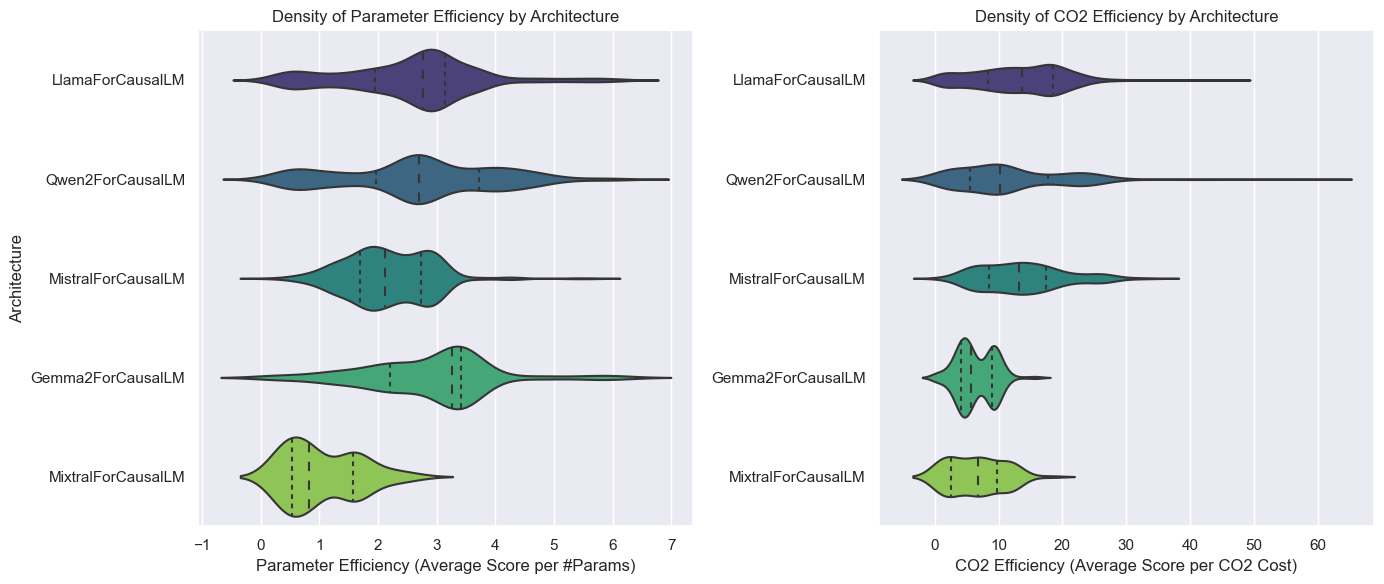

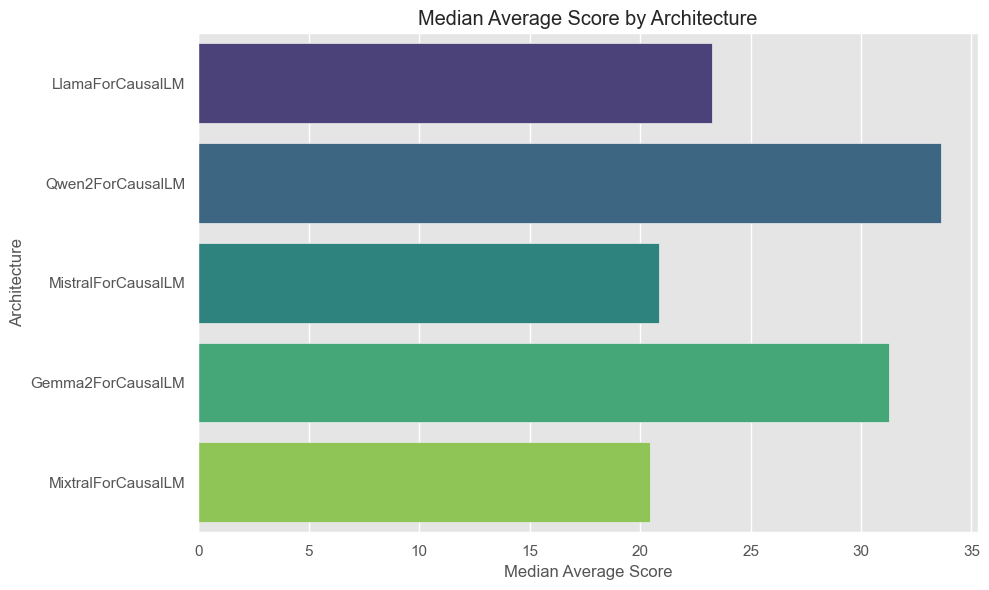

In [62]:
numeric_cols = ['#Params (B)', 'CO₂ cost (kg)']
for col in numeric_cols:
    df_top[col] = pd.to_numeric(df_top[col], errors='coerce')
    
param_median = df_top.groupby('Architecture')['#Params (B)'].median().reindex(top_archs_list)

co2_median = df_top.groupby('Architecture')['CO₂ cost (kg)'].median().reindex(top_archs_list)

top_archs_list = top_archs.index.tolist()
df_top = df[df['Architecture'].isin(top_archs_list)].copy()

numeric_cols = ['#Params (B)', 'CO₂ cost (kg)', 'Average ⬆️']
for col in numeric_cols:
    df_top[col] = pd.to_numeric(df_top[col], errors='coerce')
    
df_top = df_top[df_top['#Params (B)'] != 0]

# Parameter Efficiency: Average Score per Parameter
df_top['param_efficiency'] = df_top['Average ⬆️'] / df_top['#Params (B)']

# CO2 Emission Efficiency: Average Score per CO₂ cost
df_top['co2_efficiency'] = df_top['Average ⬆️'] / df_top['CO₂ cost (kg)']

df_top = df_top[(df_top['param_efficiency'] >= 0) & (df_top['co2_efficiency'] >= 0)]

Q1 = df_top['param_efficiency'].quantile(0.25)
Q3 = df_top['param_efficiency'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

df_top = df_top[df_top['param_efficiency'] <= upper_bound]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(ax=axes[0], x='param_efficiency', y='Architecture', data=df_top, order=top_archs_list, 
               palette='viridis', inner='quartile')
axes[0].set_title('Density of Parameter Efficiency by Architecture')
axes[0].set_xlabel('Parameter Efficiency (Average Score per #Params)')
axes[0].set_ylabel('Architecture')

sns.violinplot(ax=axes[1], x='co2_efficiency', y='Architecture', data=df_top, order=top_archs_list, 
               palette='viridis', inner='quartile')
axes[1].set_title('Density of CO2 Efficiency by Architecture')
axes[1].set_xlabel('CO2 Efficiency (Average Score per CO2 Cost)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('violin2.png', dpi=300, bbox_inches='tight')
plt.show()

sns.set_theme(style="whitegrid")

avg_median = df_top.groupby('Architecture')['Average ⬆️'].median().reindex(top_archs_list)

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_median.values, y=avg_median.index, palette='viridis')
plt.title('Median Average Score by Architecture')
plt.xlabel('Median Average Score')
plt.ylabel('Architecture')
plt.tight_layout()
plt.savefig('median_average_by_architecture.png', dpi=300, bbox_inches='tight')
plt.show()

In [63]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
file_path = "data_4072.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.columns

Index(['eval_name', 'Precision', 'Type', 'T', 'Weight type', 'Architecture',
       'Model', 'fullname', 'Model sha', 'Average ⬆️', 'Hub License', 'Hub ❤️',
       '#Params (B)', 'Available on the hub', 'MoE', 'Flagged',
       'Chat Template', 'CO₂ cost (kg)', 'IFEval Raw', 'IFEval', 'BBH Raw',
       'BBH', 'MATH Lvl 5 Raw', 'MATH Lvl 5', 'GPQA Raw', 'GPQA', 'MUSR Raw',
       'MUSR', 'MMLU-PRO Raw', 'MMLU-PRO', 'Merged', 'Official Providers',
       'Upload To Hub Date', 'Submission Date', 'Generation', 'Base Model'],
      dtype='object')

In [65]:
metrics_columns = ["Type", "Base Model", "Architecture", "Average ⬆️", "IFEval", "BBH", "MATH Lvl 5", "GPQA", "MUSR", "MMLU-PRO", "CO₂ cost (kg)", "#Params (B)", "Hub ❤️"]
df_filtered = df[["eval_name"] + metrics_columns]
metrics = ["IFEval", "BBH", "MATH Lvl 5", "GPQA", "MUSR", "MMLU-PRO"]
df_nonzero_params = df[df["#Params (B)"] > 0].copy()

stats_summary = df_filtered.describe()
stats_summary

Average ⬆️       IFEval          BBH   MATH Lvl 5         GPQA  \
count  4072.000000  4072.000000  4072.000000  4072.000000  4072.000000   
mean     21.563153    45.143434    27.597370    14.730475     6.664493   
std      10.514242    20.221352    14.925950    13.932779     4.980286   
min       0.737851     0.000000     0.251527     0.000000     0.000000   
25%      13.943018    27.490586    16.817051     4.229607     2.684564   
50%      21.796067    44.549628    29.497743    10.196375     5.928412   
75%      28.560681    61.238348    36.353330    21.072508     9.284116   
max      52.081384    89.975820    76.699968    71.450151    29.418345   

              MUSR     MMLU-PRO  CO₂ cost (kg)  #Params (B)       Hub ❤️  
count  4072.000000  4072.000000    4072.000000  4072.000000  4072.000000  
mean      9.915619    25.327526       4.255001    11.496813    54.521120  
std       5.720160    13.924341      11.441319    15.286623   281.305087  
min       0.000000     0.000000       0.039245    -1.000000     0.000000  
25%       5.134375    16.230330       1.248653     6.061000     0.000000  
50%       9.947266    27.184914       1.618019     8.030000     1.000000  
75%      13.474284    33.300550       2.902852    12.248000     8.000000  
max      38.528906    70.033614     186.610443   140.630000  6053.000000

## Metric Intro

1. **IFEval**: Evaluates the model's performance on instruction following tasks.

2. **BBH**: Evaluates the model's complex logical reasoning ability.

3. **MATH Lvl 5**: Evaluates the model's ability to solve difficult math problems.

4. **GPQA**: Evaluates the model's general question answering ability.

5. **MUSR**: Evaluates diversity and common sense reasoning ability.

6. **MMLU-PRO**: Evaluates the model's performance on the multi-task language understanding benchmark (expertise questions).

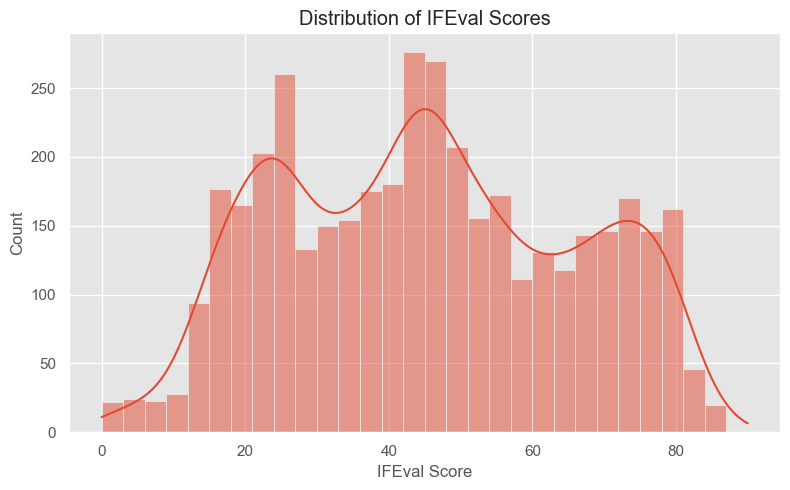

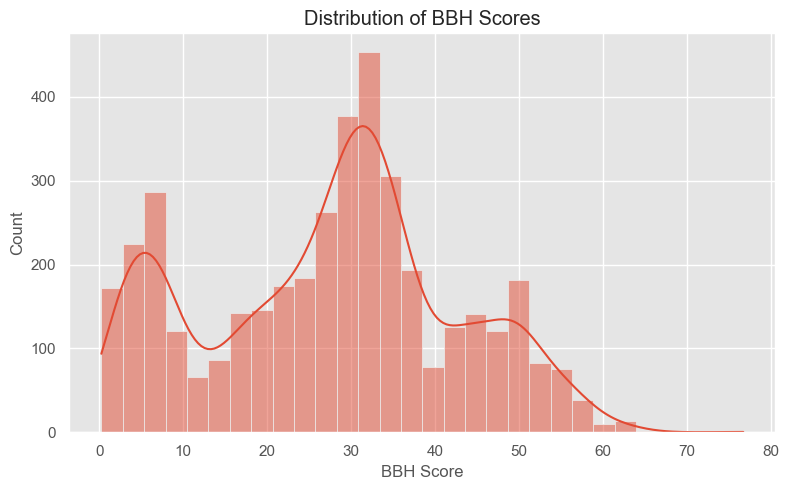

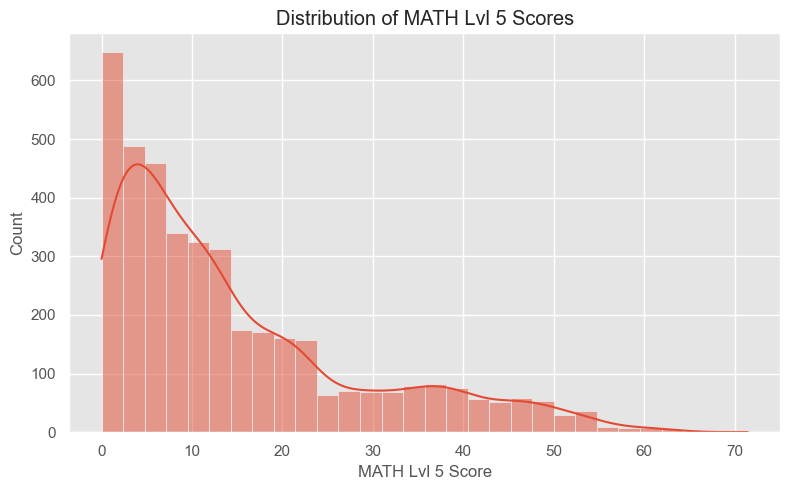

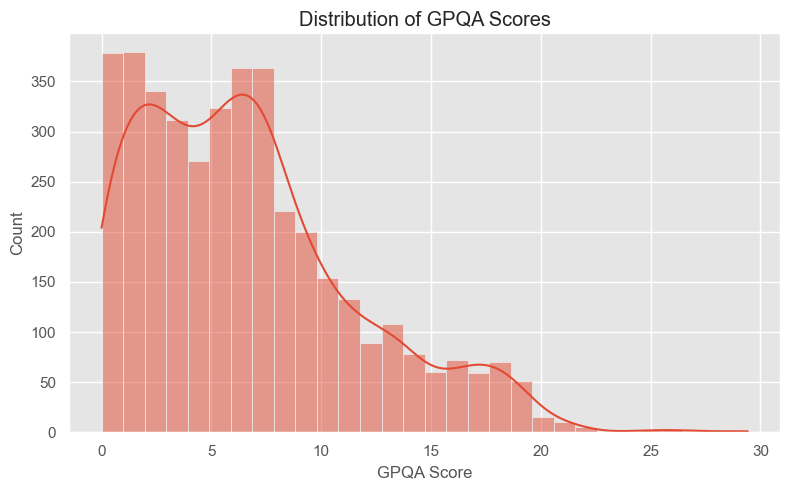

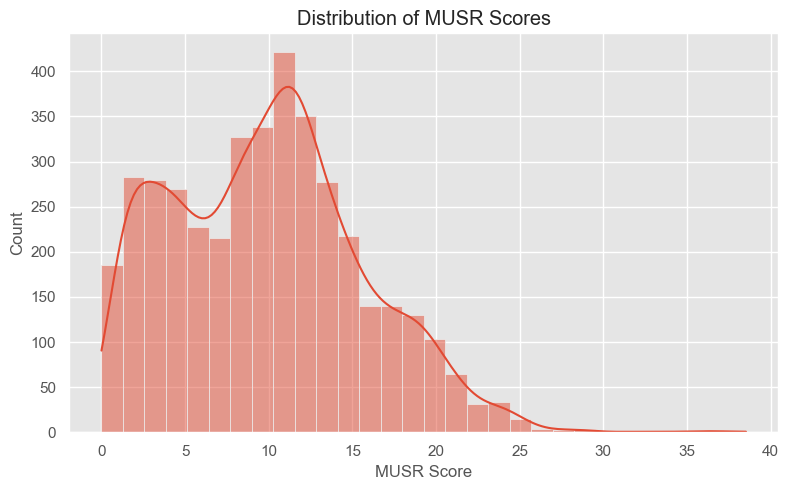

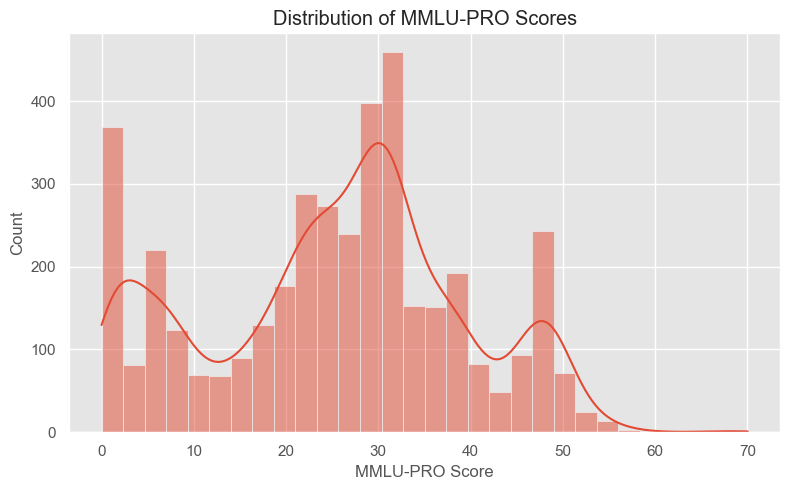

In [66]:
for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_nonzero_params[metric], bins=30, kde=True)
    plt.title(f'Distribution of {metric} Scores')
    plt.xlabel(f'{metric} Score')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Efficiency

### Top 5 Efficient

In [67]:
df_nonzero_params = df[df["#Params (B)"] > 0].copy()
df_nonzero_params["Efficiency"] = df_nonzero_params["Average ⬆️"] / df_nonzero_params["#Params (B)"]

top_efficiency_models_full = df_nonzero_params.sort_values(by="Efficiency", ascending=False).head()

top_efficiency_models_full[["eval_name", "Average ⬆️", "#Params (B)", "Efficiency", "Architecture", "Type"]]


eval_name  Average ⬆️  \
2199  darkc0de_BuddyGlass_v0.3_Xortron7MethedUpSwitc...   22.328255   
2193                    cpayne1303_smallcp2024_bfloat16    3.543848   
2190                cpayne1303_cp2024-instruct_bfloat16    4.319731   
2192                  cpayne1303_llama-43m-beta_float16    5.422629   
2191                 cpayne1303_llama-43m-beta_bfloat16    5.288332   

      #Params (B)   Efficiency      Architecture                       Type  
2199        0.007  3189.750777  LlamaForCausalLM  🤝 base merges and moerges  
2193        0.002  1771.924217  LlamaForCausalLM               🟢 pretrained  
2190        0.031   139.346173  LlamaForCausalLM  🟩 continuously pretrained  
2192        0.043   126.107646  LlamaForCausalLM  🟩 continuously pretrained  
2191        0.043   122.984458  LlamaForCausalLM  🟩 continuously pretrained

### Top 5 Efficient (AVG > 30)

In [68]:
high_score_df = df_nonzero_params[df_nonzero_params["Average ⬆️"] >= 30].copy()

high_score_df["Efficiency"] = high_score_df["Average ⬆️"] / high_score_df["#Params (B)"]

top_5_efficient_high_score_models = high_score_df.sort_values(by="Efficiency", ascending=False).head(5)

top_5_efficient_high_score_models[["eval_name", "Average ⬆️", "#Params (B)", "Efficiency", "Architecture", "Type"]]

eval_name  Average ⬆️  \
2068    brgx53_3Bgeneralv2-ECE-PRYMMAL-Martial_bfloat16   31.482397   
1196     PJMixers-Dev_Qwen2.5-RomboTiesTest-7B_bfloat16   35.288854   
374        DreadPoor_Here_We_Go_Again-8B-SLERP_bfloat16   30.129656   
1750  Xiaojian9992024_Qwen2.5-Dyanka-7B-Preview_bflo...   37.295944   
3848                tiiuae_Falcon3-7B-Instruct_bfloat16   36.404685   

      #Params (B)  Efficiency      Architecture  \
2068        3.000   10.494132  Qwen2ForCausalLM   
1196        3.808    9.267031  Qwen2ForCausalLM   
374         4.015    7.504273  LlamaForCausalLM   
1750        7.616    4.897052  Qwen2ForCausalLM   
3848        7.456    4.882603  LlamaForCausalLM   

                                     Type  
2068            🤝 base merges and moerges  
1196            🤝 base merges and moerges  
374             🤝 base merges and moerges  
1750            🤝 base merges and moerges  
3848  💬 chat models (RLHF, DPO, IFT, ...)

- The top 5 efficient models all use the **Qwen2ForCausalLM** or **LlamaForCausalLM** architecture, which shows that these two architectures can maintain a small parameter scale while achieving high performance and show high computational efficiency.

- Most of the types belong to base merges and moerges, which means that it may be easier to obtain efficient models by merging models.

In [69]:
# Filter models with Average ⬆️ score ≥ 30
# high_score_df = df_nonzero_params[df_nonzero_params["Average ⬆️"] >= 30].copy()
high_score_df = df_nonzero_params.copy()

# Calculate Parameter Efficiency
high_score_df["Param Efficiency"] = high_score_df["Average ⬆️"] / high_score_df["#Params (B)"]

# Calculate Environmental Efficiency (avoid division by zero)
high_score_df = high_score_df[high_score_df['CO₂ cost (kg)'] > 0]
high_score_df["Env Efficiency"] = high_score_df["Average ⬆️"] / high_score_df["CO₂ cost (kg)"]

# Show top 5 models by Param Efficiency
top5_param_efficiency = high_score_df.sort_values(by="Param Efficiency", ascending=False).head(5)

# Show both efficiencies clearly
top5_param_efficiency[[
    "eval_name", "Average ⬆️", "#Params (B)", "CO₂ cost (kg)",
    "Param Efficiency", "Architecture", "Type"
]]

# Similarly, top 5 by Environmental Efficiency
top5_env_efficiency = high_score_df.sort_values(by="Average ⬆️", ascending=False).head(5)

top5_param_efficiency, top5_param_efficiency[[
    "eval_name", "Average ⬆️", "#Params (B)", "CO₂ cost (kg)", "Param Efficiency", "Architecture", "Type"
]]

(                                              eval_name Precision  \
 2199  darkc0de_BuddyGlass_v0.3_Xortron7MethedUpSwitc...  bfloat16   
 2193                    cpayne1303_smallcp2024_bfloat16  bfloat16   
 2190                cpayne1303_cp2024-instruct_bfloat16  bfloat16   
 2192                  cpayne1303_llama-43m-beta_float16   float16   
 2191                 cpayne1303_llama-43m-beta_bfloat16  bfloat16   
 
                            Type  T Weight type      Architecture  \
 2199  🤝 base merges and moerges  🤝    Original  LlamaForCausalLM   
 2193               🟢 pretrained  🟢    Original  LlamaForCausalLM   
 2190  🟩 continuously pretrained  🟩    Original  LlamaForCausalLM   
 2192  🟩 continuously pretrained  🟩    Original  LlamaForCausalLM   
 2191  🟩 continuously pretrained  🟩    Original  LlamaForCausalLM   
 
                                                   Model  \
 2199  <a target="_blank" href="https://huggingface.c...   
 2193  <a target="_blank" href="https://hu

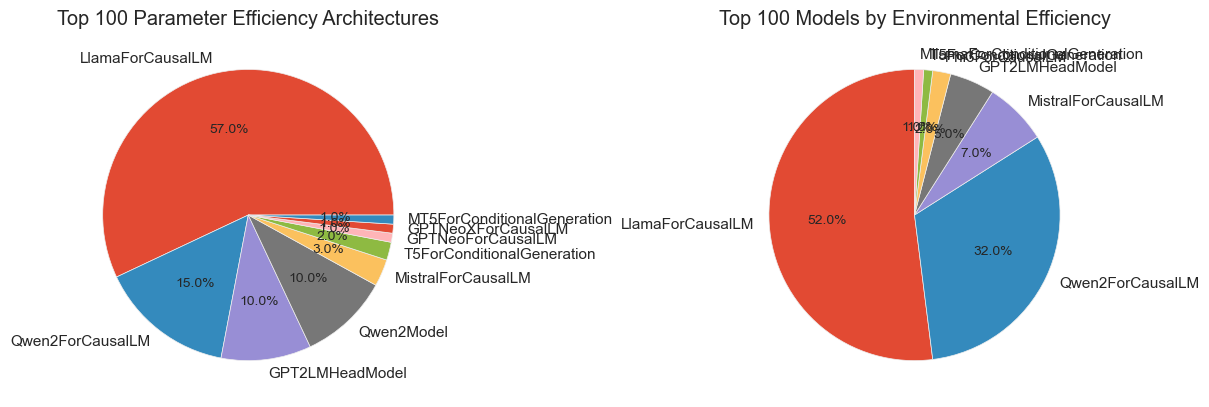

In [70]:
import matplotlib.pyplot as plt

top_100_param_eff = high_score_df.sort_values("Param Efficiency", ascending=False).head(100)
param_arch_counts = top_100_param_eff["Architecture"].value_counts()

high_score_df_nonzero_co2 = high_score_df[high_score_df["CO₂ cost (kg)"] > 0].copy()
high_score_df["Environmental Efficiency"] = high_score_df["Average ⬆️"] / high_score_df["CO₂ cost (kg)"]
top_100_env_eff = high_score_df.sort_values("Environmental Efficiency", ascending=False).head(100)
env_arch_counts = top_100_env_eff["Architecture"].value_counts()

plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
plt.subplot(1, 2, 1)
param_arch_counts.plot.pie(autopct='%1.1f%%')
plt.title('Top 100 Parameter Efficiency Architectures')
plt.ylabel("")

plt.subplot(1, 2, 2)
env_arch_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Top 100 Models by Environmental Efficiency")
plt.ylabel('')

plt.tight_layout()
plt.show()


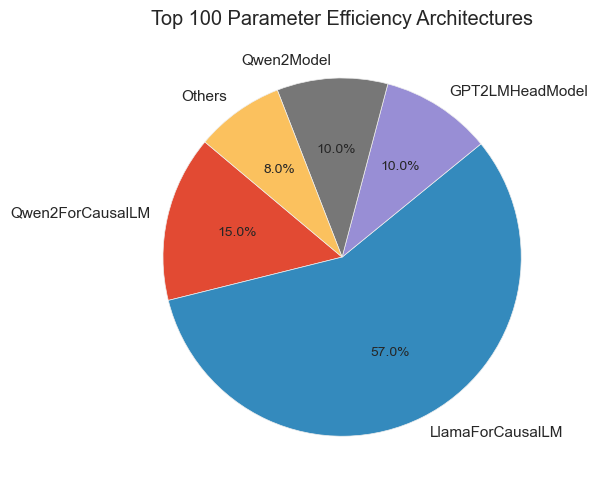

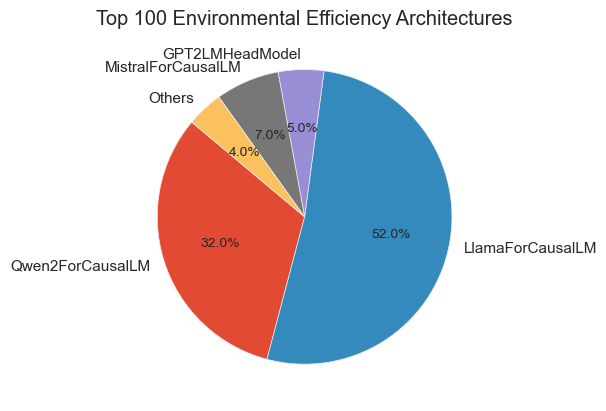

In [71]:
import matplotlib.pyplot as plt

param_top2 = ["Qwen2ForCausalLM", "LlamaForCausalLM", "GPT2LMHeadModel", "Qwen2Model"]

param_arch_counts = top_100_param_eff["Architecture"].value_counts()

param_top2_counts = [param_arch_counts.get(arch, 0) for arch in param_top2]
param_others = param_arch_counts.drop(param_top2, errors='ignore').sum()
param_sizes = param_top2_counts + [param_others] 
param_labels = param_top2 + ["Others"]       

plt.figure(figsize=(6, 6))
plt.style.use('ggplot')
plt.pie(
    param_sizes, 
    labels=param_labels, 
    autopct='%1.1f%%', 
    # colors=colors, 
    startangle=140
)
plt.title("Top 100 Parameter Efficiency Architectures")
plt.tight_layout()
plt.show()


# =============== Environmental Efficiency ===============
env_top2 = ["Qwen2ForCausalLM", "LlamaForCausalLM", "GPT2LMHeadModel", "MistralForCausalLM"]

env_arch_counts = top_100_env_eff["Architecture"].value_counts()

env_top2_counts = [env_arch_counts.get(arch, 0) for arch in env_top2]
env_others = env_arch_counts.drop(env_top2, errors='ignore').sum()
env_sizes = env_top2_counts + [env_others]
env_labels = env_top2 + ["Others"]

plt.figure(figsize=(6, 6))
plt.style.use('ggplot')
plt.pie(
    env_sizes, 
    labels=env_labels, 
    autopct='%1.1f%%', 
    # colors=colors, 
    startangle=140
)
plt.title("Top 100 Environmental Efficiency Architectures")
plt.tight_layout()
plt.show()


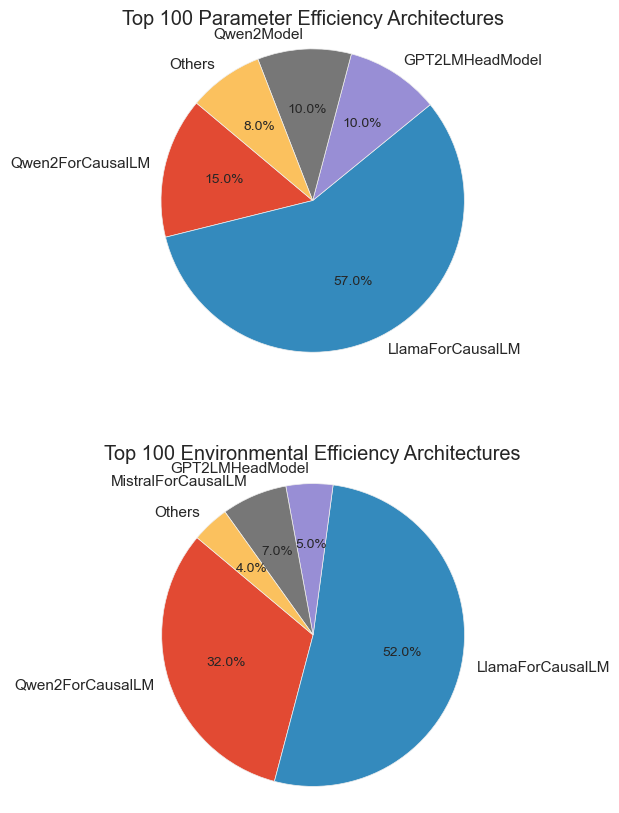

In [72]:
import matplotlib.pyplot as plt

# =============== Parameter Efficiency ===============
param_top2 = ["Qwen2ForCausalLM", "LlamaForCausalLM", "GPT2LMHeadModel", "Qwen2Model"]
param_arch_counts = top_100_param_eff["Architecture"].value_counts()
param_top2_counts = [param_arch_counts.get(arch, 0) for arch in param_top2]
param_others = param_arch_counts.drop(param_top2, errors='ignore').sum()
param_sizes = param_top2_counts + [param_others]
param_labels = param_top2 + ["Others"]

# =============== Environmental Efficiency ===============
env_top2 = ["Qwen2ForCausalLM", "LlamaForCausalLM", "GPT2LMHeadModel", "MistralForCausalLM"]
env_arch_counts = top_100_env_eff["Architecture"].value_counts()
env_top2_counts = [env_arch_counts.get(arch, 0) for arch in env_top2]
env_others = env_arch_counts.drop(env_top2, errors='ignore').sum()
env_sizes = env_top2_counts + [env_others]
env_labels = env_top2 + ["Others"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
plt.style.use('ggplot')

axes[0].pie(param_sizes, labels=param_labels, autopct='%1.1f%%', startangle=140)
axes[0].set_title("Top 100 Parameter Efficiency Architectures")
axes[0].axis('equal')

axes[1].pie(env_sizes, labels=env_labels, autopct='%1.1f%%', startangle=140)
axes[1].set_title("Top 100 Environmental Efficiency Architectures")
axes[1].axis('equal')

plt.subplots_adjust(hspace=0.3)

plt.show()


### Efficiency vs Architechture

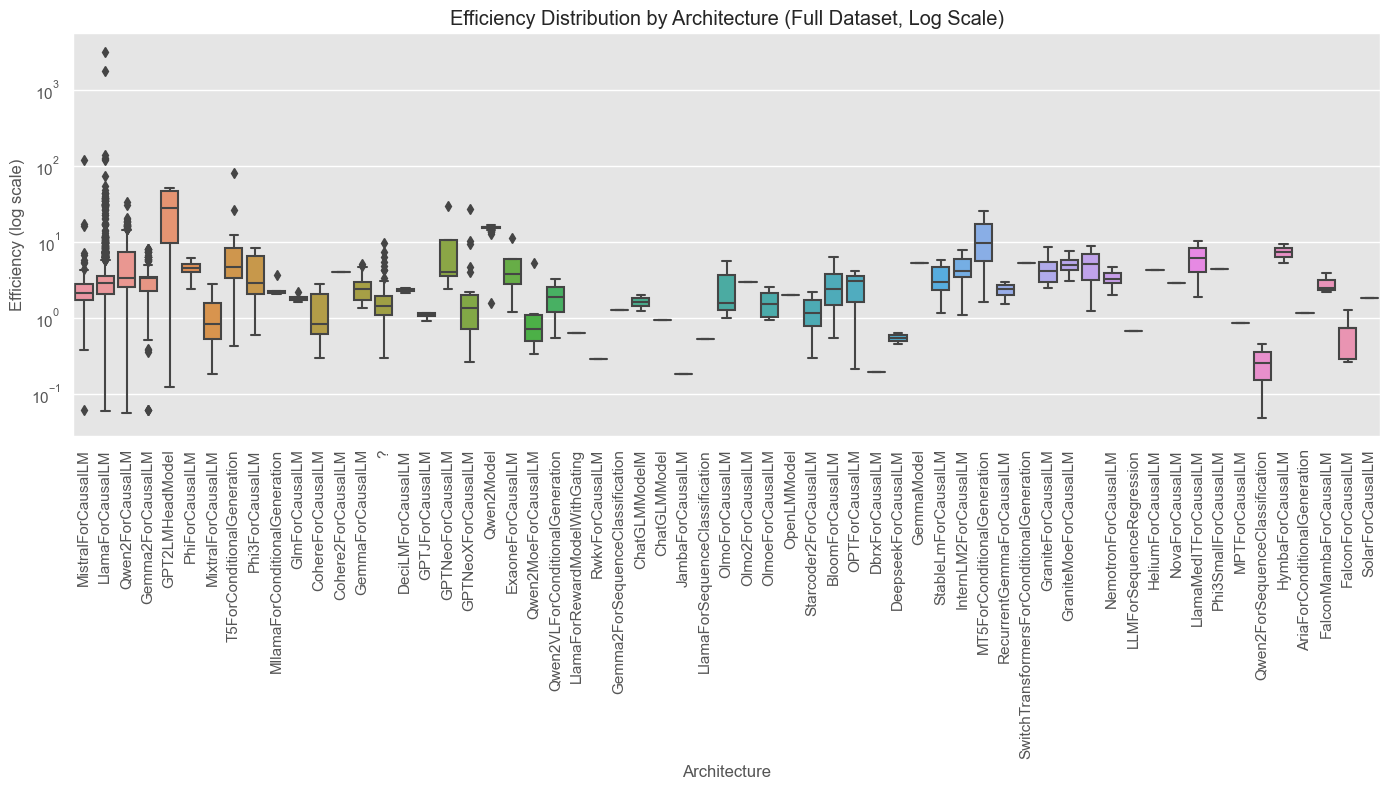

In [73]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_nonzero_params, x='Architecture', y='Efficiency')
plt.xticks(rotation=90)
plt.yscale('log') 
plt.title("Efficiency Distribution by Architecture (Full Dataset, Log Scale)")
plt.xlabel("Architecture")
plt.ylabel("Efficiency (log scale)")
plt.tight_layout()
plt.show()


- Architectures such as **LlamaForCausalLM** and **MistralForCausalLM** generally have high efficiency performance, among which LlamaForCausalLM has multiple extremely high efficiency outliers, indicating that this architecture can achieve significant performance advantages at a small scale.

- Architectures such as **MixtralForCausalLM** and **PhiForCausalLM** also show relatively good median efficiency, indicating that these architectures have achieved a good balance between parameters and performance.

- Some architectures (such as **FalconForCausalLM** and **BloomForCausalLM**) have relatively poor efficiency performance, indicating that larger model parameters are required to achieve the same performance.

### Efficiency vs Architechture (AVG > 30)

/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0, flags=flags)


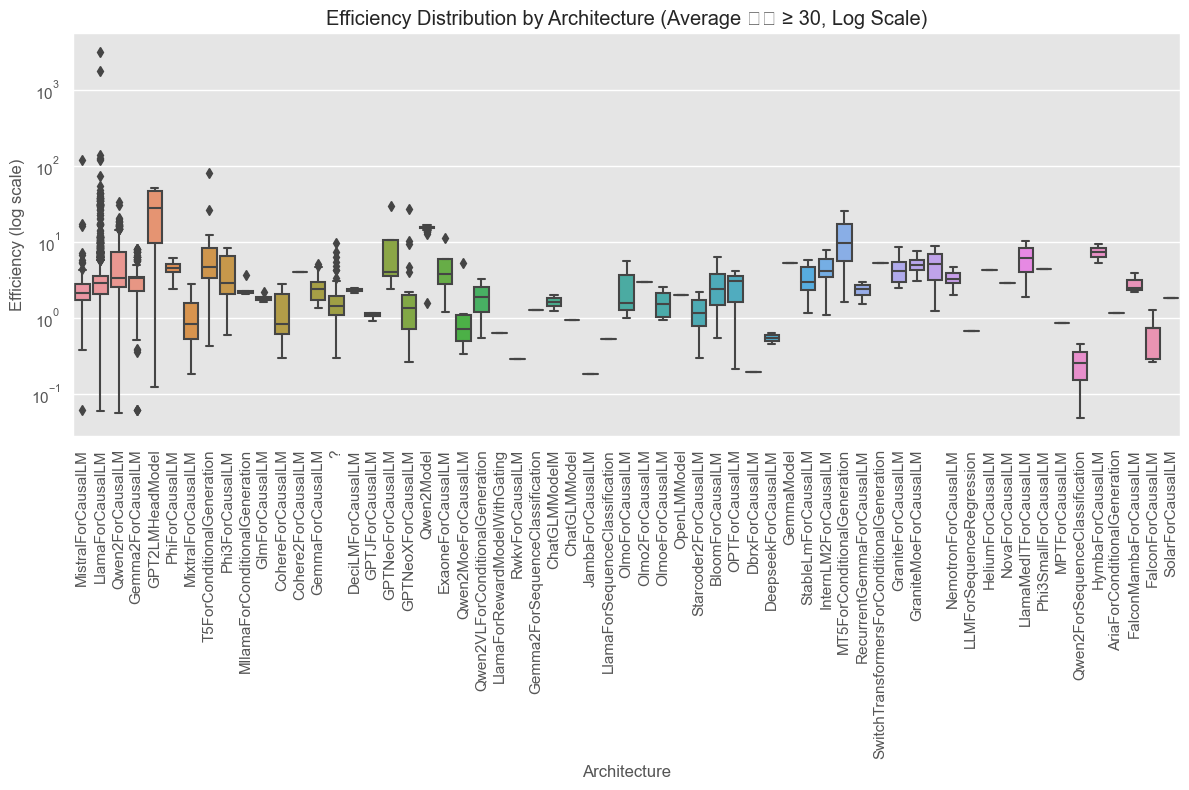

In [74]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=high_score_df, x='Architecture', y='Efficiency')
plt.xticks(rotation=90)
plt.yscale('log')  
plt.title("Efficiency Distribution by Architecture (Average ⬆️ ≥ 30, Log Scale)")
plt.xlabel("Architecture")
plt.ylabel("Efficiency (log scale)")
plt.tight_layout()
plt.show()


- The efficiency performance of **Qwen2ForCausalLM** and **LlamaForCausalLM** architectures is relatively outstanding, with not only a higher median but also a wider distribution range, which means that these architectures can achieve higher performance within a smaller parameter scale.

- Although some architectures such as **MixtralForCausalLM** and **GemmaForCausalLM** also achieve high performance (Average ≥ 30), the distribution of efficiency is more concentrated or overall low, indicating that these architectures may rely more on a larger parameter scale.

## Popularity

In [75]:
top_10_popular_models = df_nonzero_params.sort_values(by="Hub ❤️", ascending=False).head(10)

top_10_popular_models[["eval_name", "Hub ❤️", "Average ⬆️", "#Params (B)", "Architecture", "Type"]]


eval_name  Hub ❤️  Average ⬆️  \
3052             meta-llama_Meta-Llama-3-8B_bfloat16    6053   13.626857   
3107   mistralai_Mixtral-8x7B-Instruct-v0.1_bfloat16    4316   23.817103   
3041           meta-llama_Llama-2-7b-chat-hf_float16    4252    9.609483   
3054     meta-llama_Meta-Llama-3-8B-Instruct_float16    3836   20.609159   
3053    meta-llama_Meta-Llama-3-8B-Instruct_bfloat16    3836   23.908736   
3058  meta-llama_Meta-Llama-3.1-8B-Instruct_bfloat16    3669   28.204458   
3044        meta-llama_Llama-3.1-8B-Instruct_float16    3669   23.763729   
3097              mistralai_Mistral-7B-v0.1_bfloat16    3602   14.575359   
3074                         microsoft_phi-2_float16    3278   15.534292   
2422                        google_gemma-7b_bfloat16    3123   15.442819   

      #Params (B)        Architecture                                 Type  
3052        8.030    LlamaForCausalLM                         🟢 pretrained  
3107       46.703  MixtralForCausalLM  💬 chat models (RLHF, DPO, IFT, ...)  
3041        6.738    LlamaForCausalLM                         🟢 pretrained  
3054        8.030    LlamaForCausalLM  💬 chat models (RLHF, DPO, IFT, ...)  
3053        8.030    LlamaForCausalLM  💬 chat models (RLHF, DPO, IFT, ...)  
3058        8.030    LlamaForCausalLM  💬 chat models (RLHF, DPO, IFT, ...)  
3044        8.030    LlamaForCausalLM                         🟢 pretrained  
3097        7.242  MistralForCausalLM                         🟢 pretrained  
3074        2.780      PhiForCausalLM                         🟢 pretrained  
2422        8.538    GemmaForCausalLM                         🟢 pretrained

Hub likes seems to be outdated.

## Correlation Analysis

/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/yifan/de

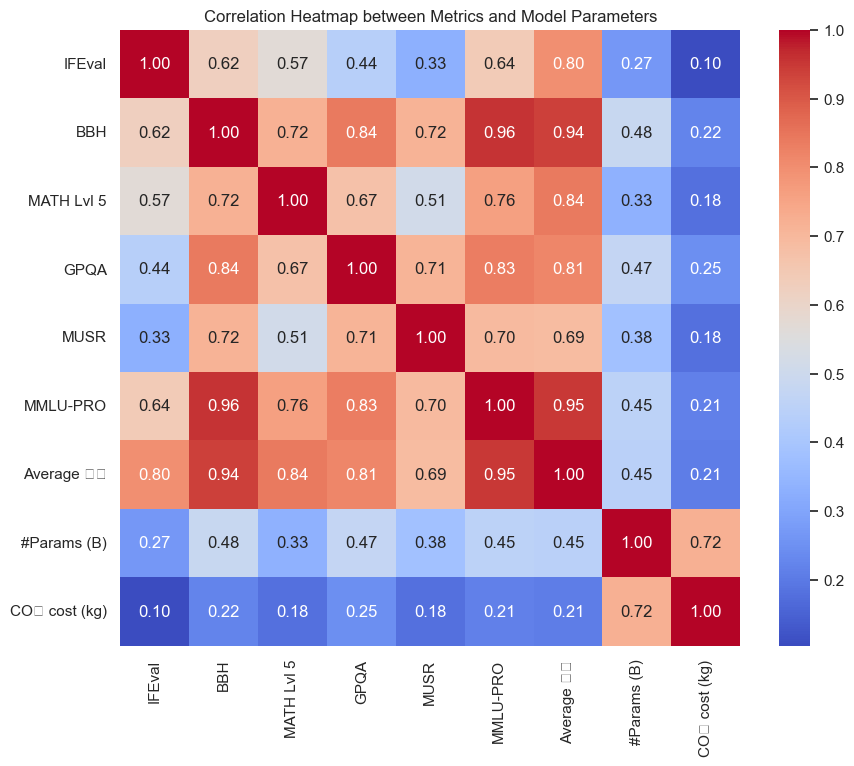

In [76]:
heatmap_columns = metrics + ["Average ⬆️"] + ["#Params (B)"] + ["CO₂ cost (kg)"]
corr_matrix = df_filtered[heatmap_columns].corr()

sns.set_theme()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap between Metrics and Model Parameters")
plt.show()


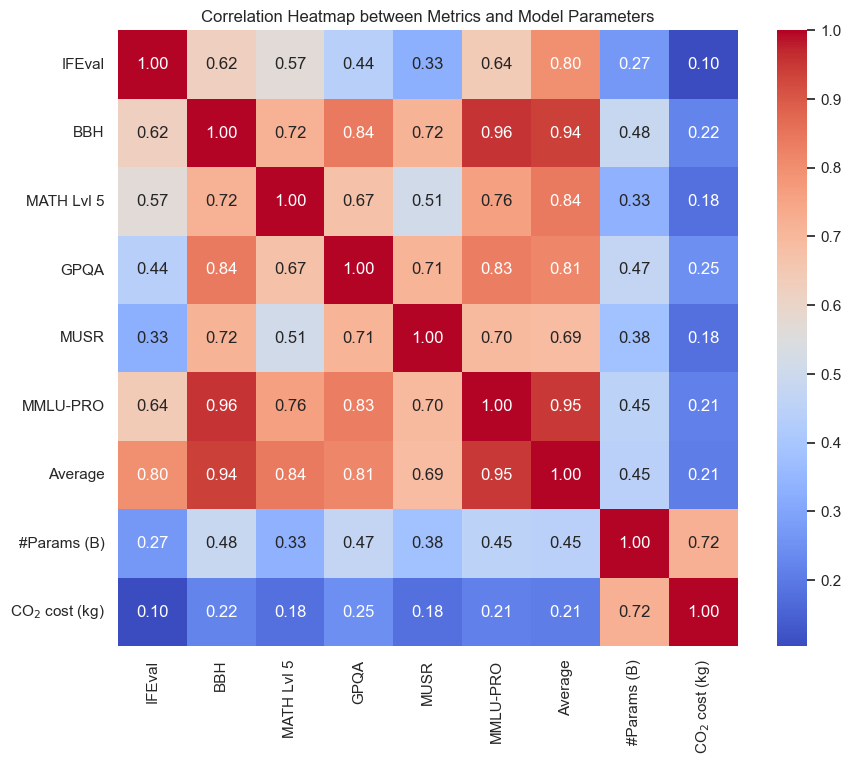

In [77]:
df_filtered_copy = df_filtered.copy()

df_filtered_copy.rename(columns={"Average ⬆️": "Average", "CO₂ cost (kg)": "CO$_2$ cost (kg)"}, inplace=True)

heatmap_columns = metrics + ["Average"] + ["#Params (B)"] + ["CO$_2$ cost (kg)"]
corr_matrix = df_filtered_copy[heatmap_columns].corr()

sns.set_theme()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap between Metrics and Model Parameters")
plt.show()



### Metrics vs Params

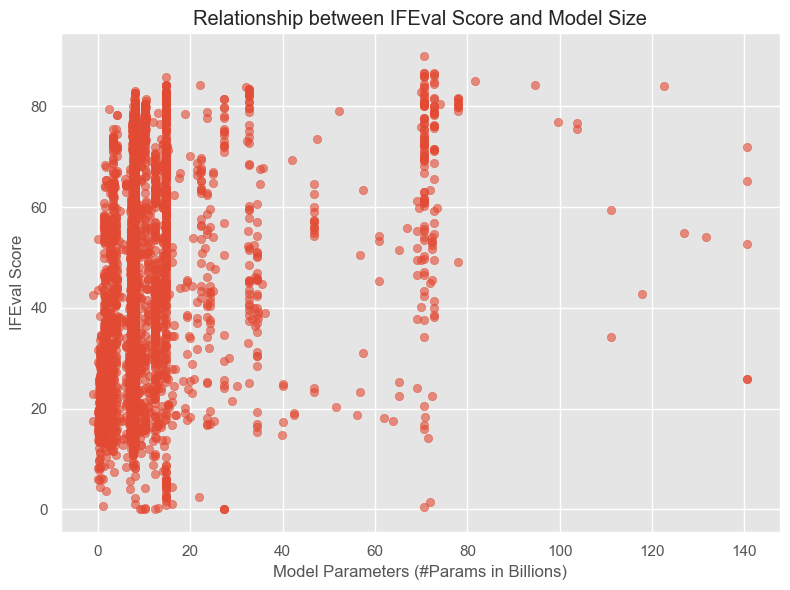

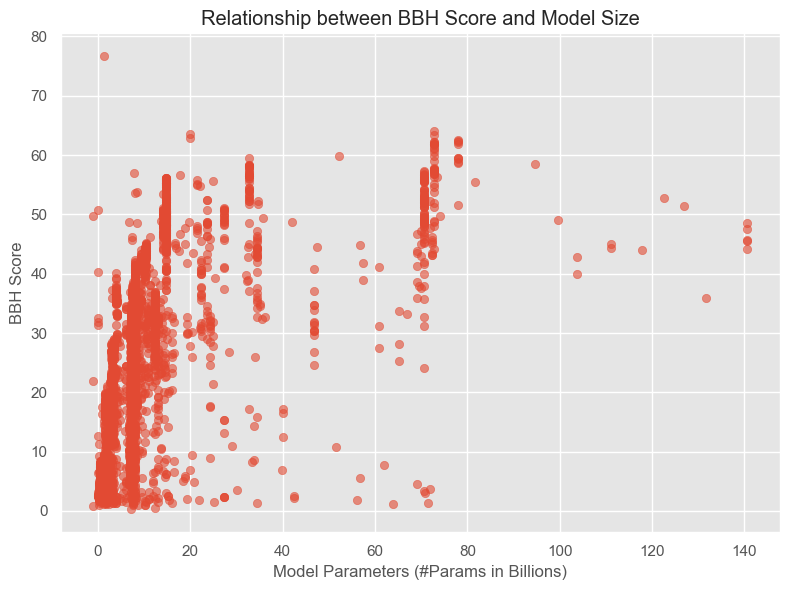

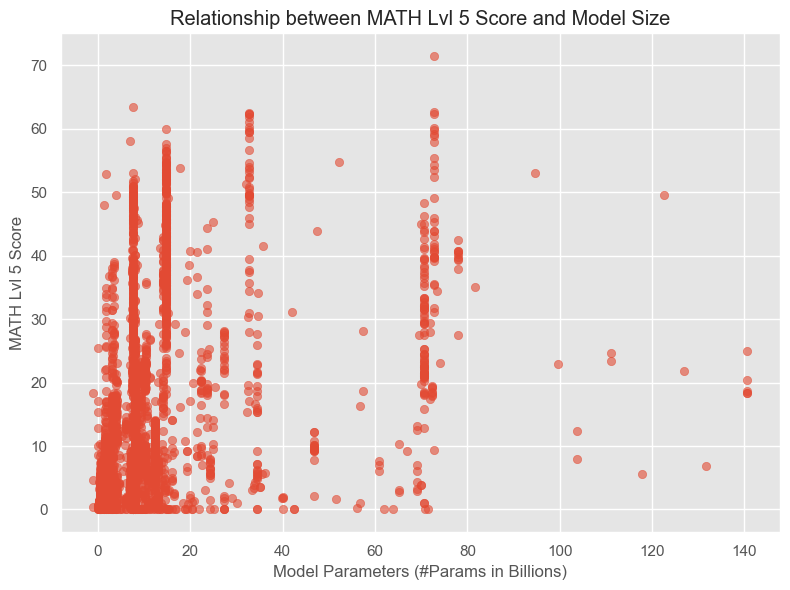

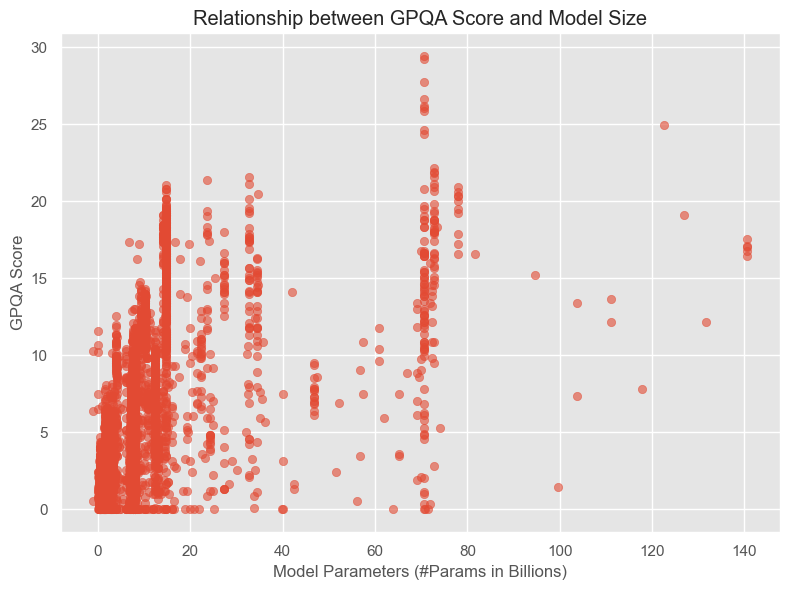

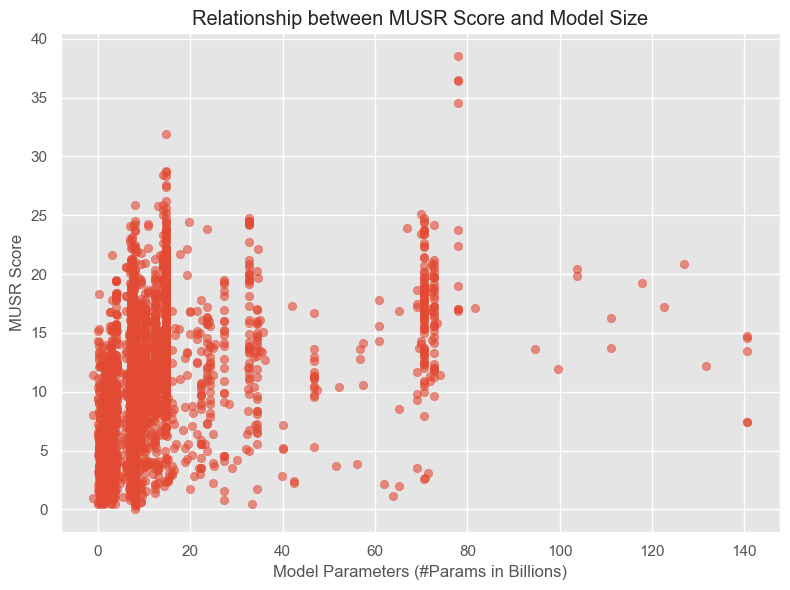

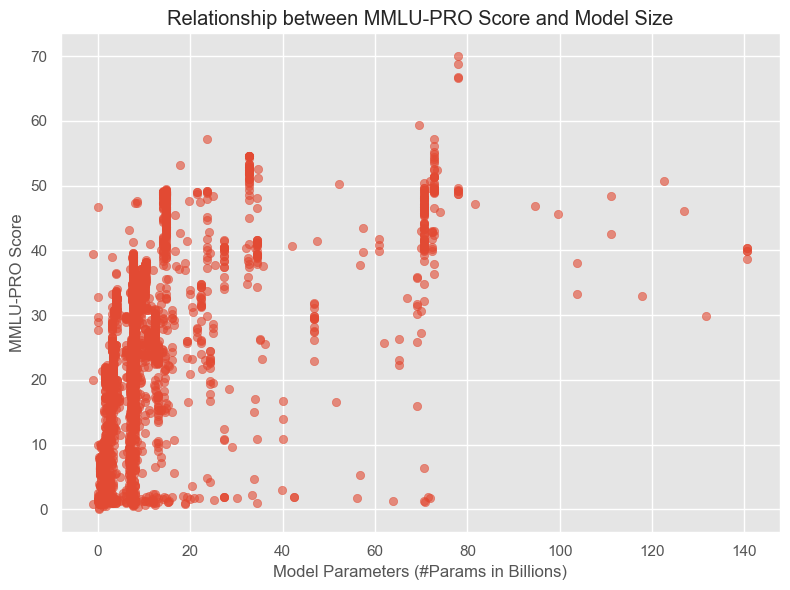

In [78]:
metrics = ["IFEval", "BBH", "MATH Lvl 5", "GPQA", "MUSR", "MMLU-PRO"]

plt.style.use('ggplot')

for metric in metrics:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_filtered["#Params (B)"], df_filtered[metric], alpha=0.6)
    plt.xlabel("Model Parameters (#Params in Billions)")
    plt.ylabel(metric + " Score")
    plt.title(f"Relationship between {metric} Score and Model Size")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Limiting parameter size to 0~40 billion

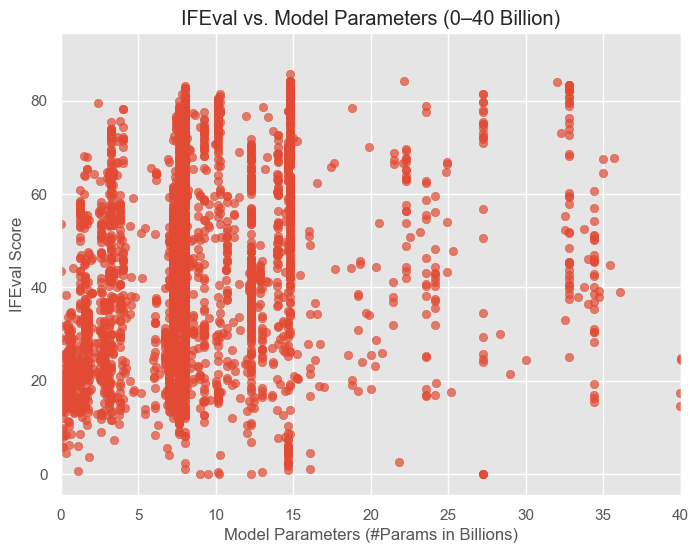

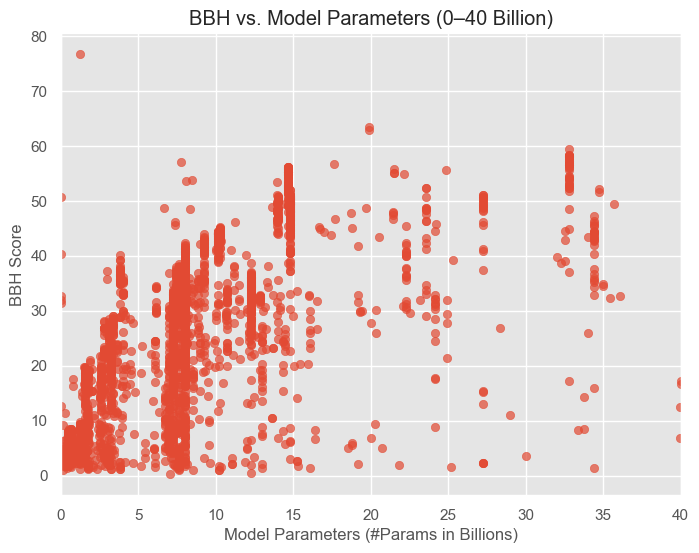

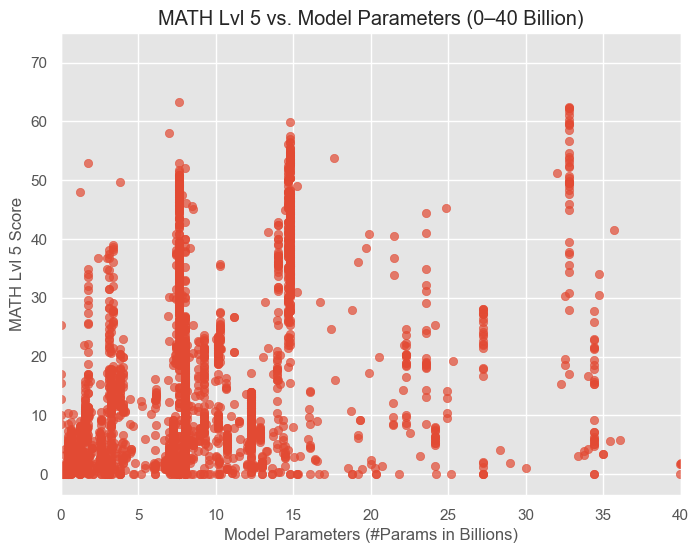

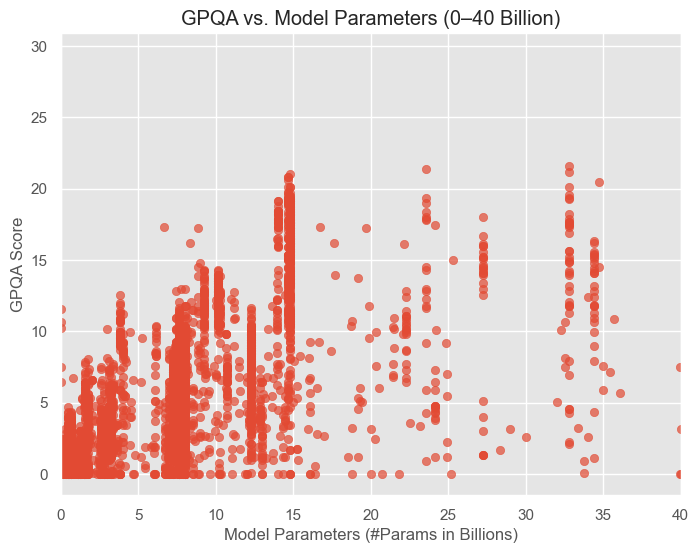

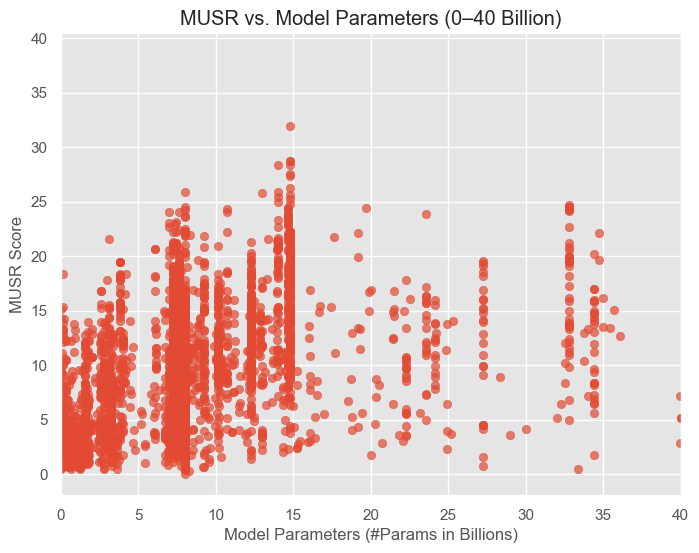

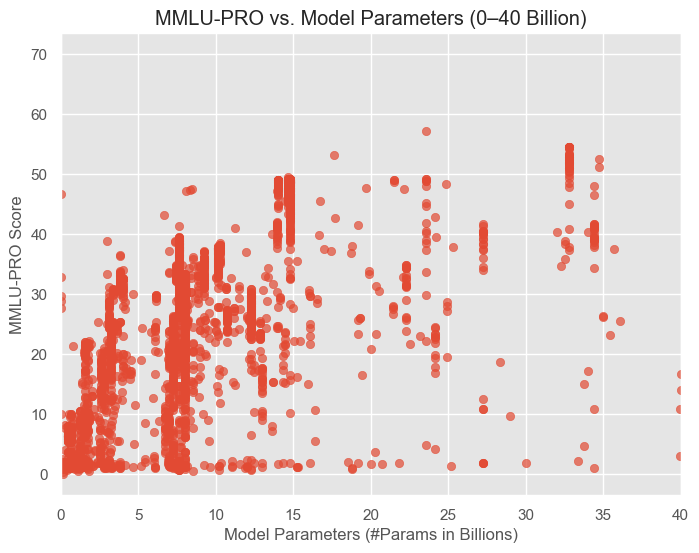

In [79]:
filtered_df_limited = df_filtered[df_filtered["#Params (B)"] <= 40]

for metric in metrics:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_filtered["#Params (B)"], df_filtered[metric], alpha=0.7)
    plt.xlabel("Model Parameters (#Params in Billions)")
    plt.ylabel(f"{metric} Score")
    plt.title(f"{metric} vs. Model Parameters (0–40 Billion)")
    plt.xlim(0, 40)
    plt.grid(True)
    plt.show()


## How to get my dream model? (How to maximize certain metrics)

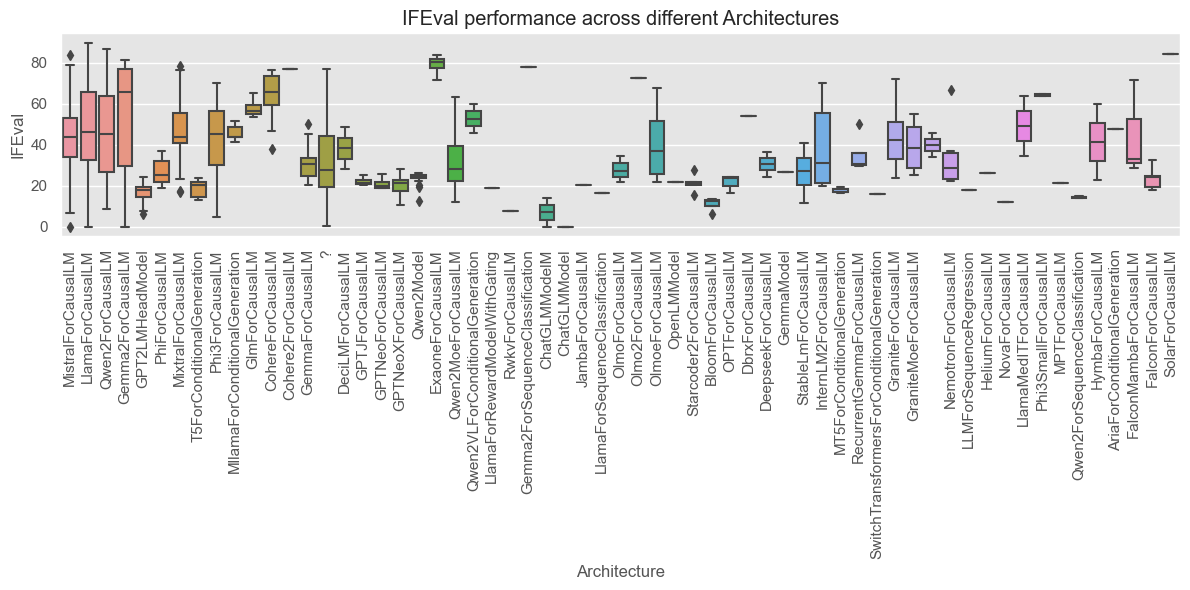

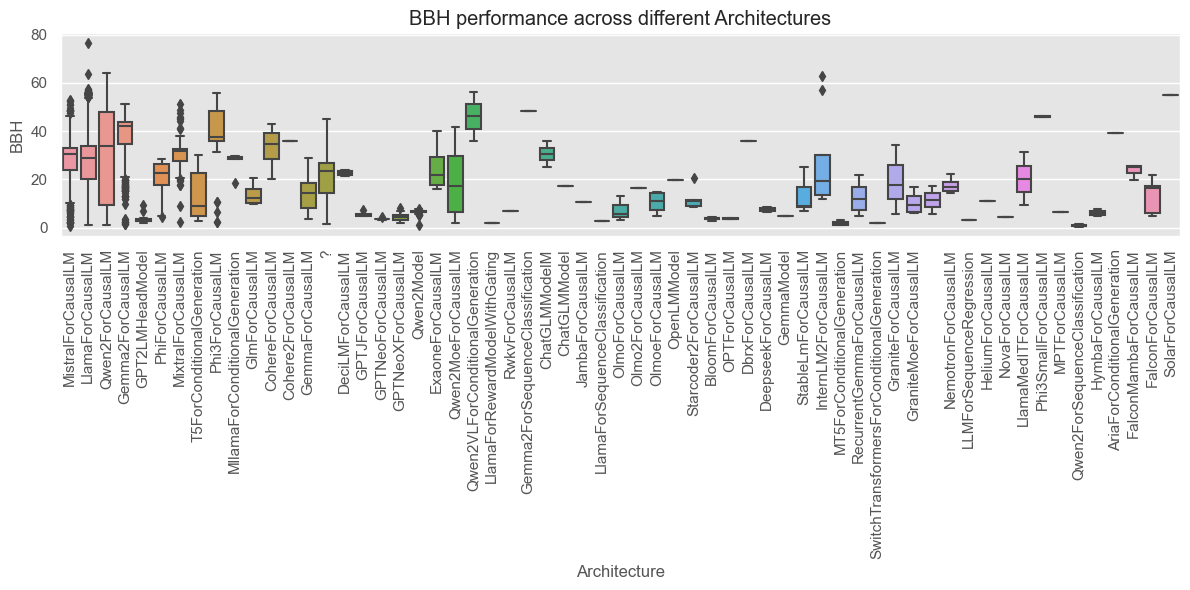

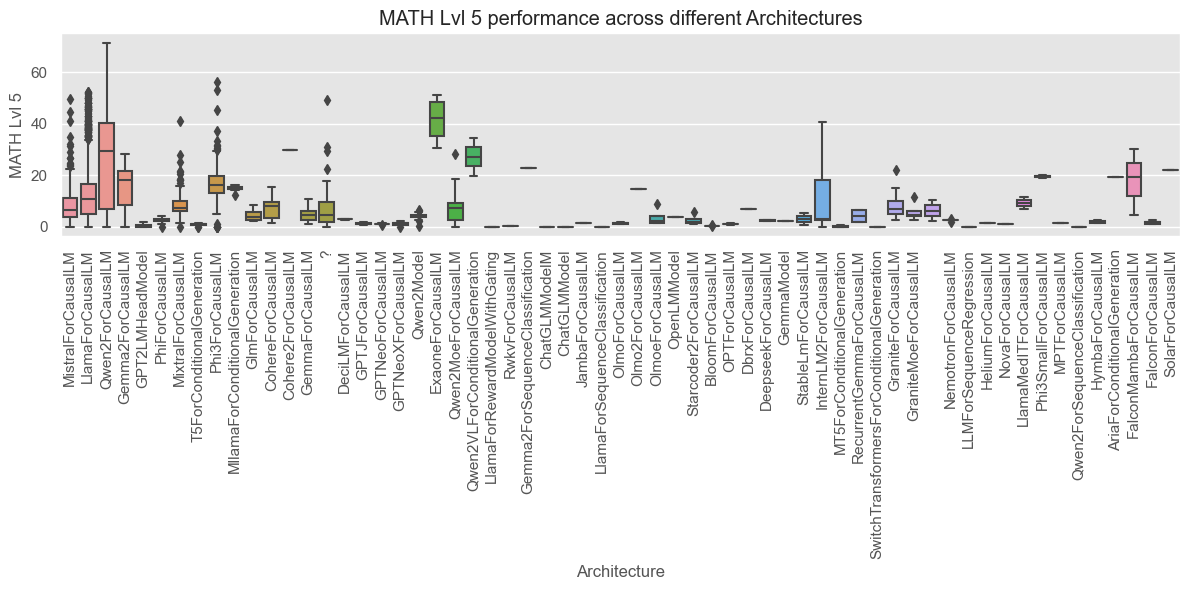

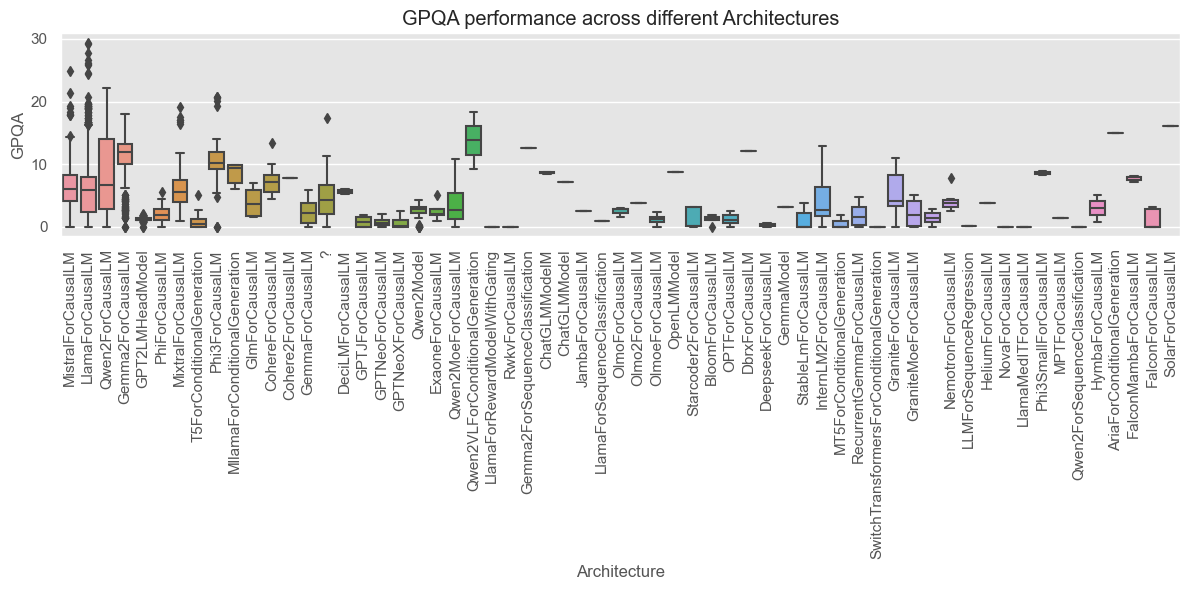

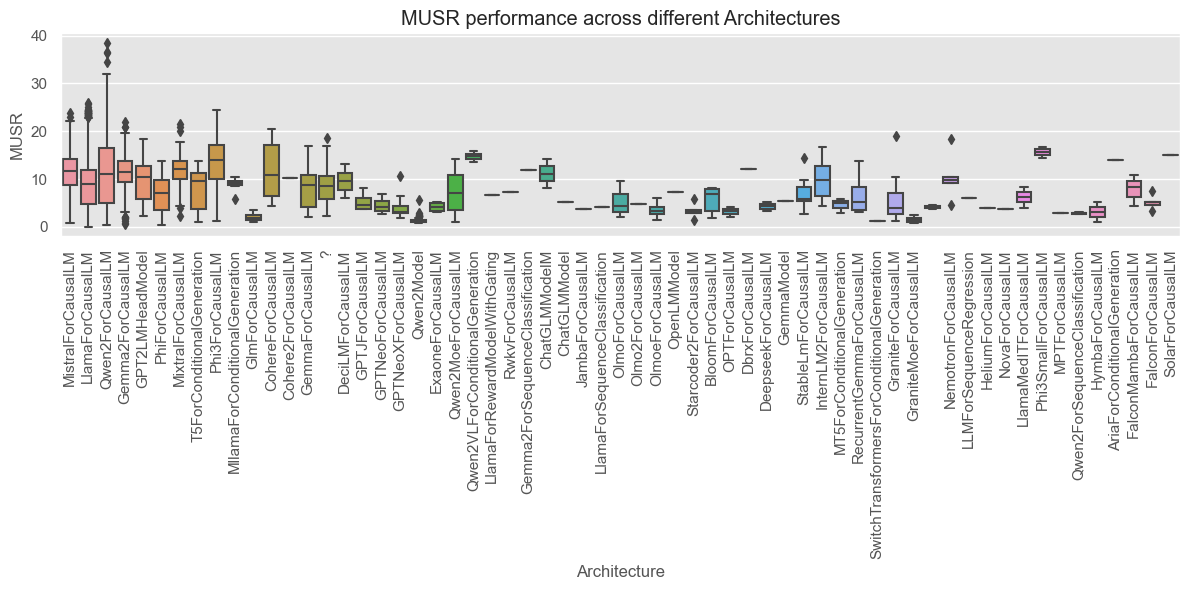

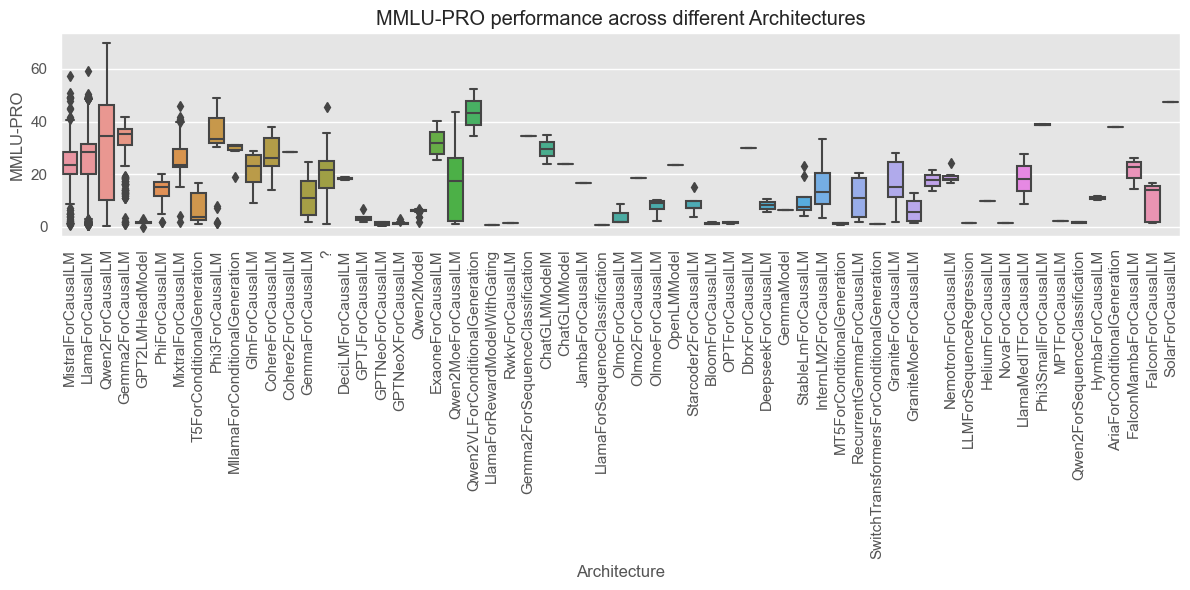

In [80]:
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_nonzero_params, x='Architecture', y=metric)
    plt.xticks(rotation=90)
    plt.title(f'{metric} performance across different Architectures')
    plt.ylabel(metric)
    plt.xlabel("Architecture")
    plt.tight_layout()
    plt.show()


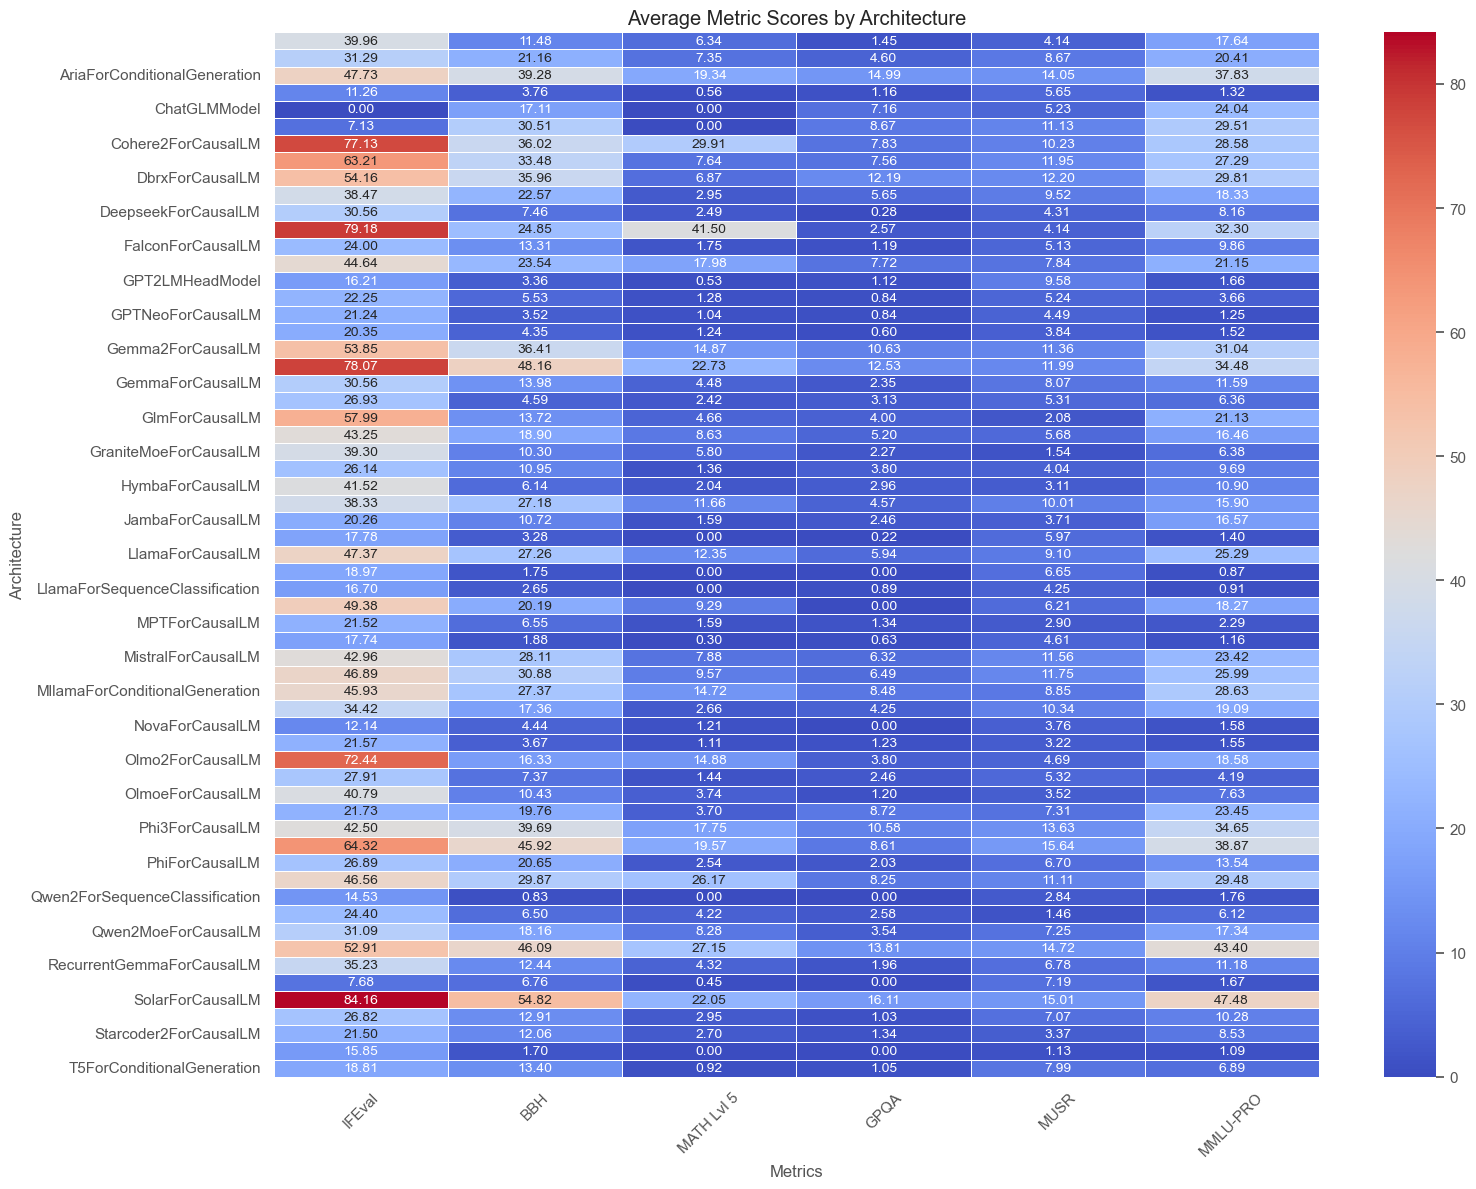

In [81]:
mean_performance_by_arch = df_nonzero_params.groupby('Architecture')[metrics].mean()
mean_performance_by_arch_cleaned = mean_performance_by_arch.dropna()

plt.figure(figsize=(16, 12))
sns.heatmap(mean_performance_by_arch, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Average Metric Scores by Architecture")
plt.xlabel("Metrics")
plt.ylabel("Architecture")
plt.tight_layout()
plt.show()


consider top 10 arch by the number of submission
null arch

In [82]:
top_10_architectures = df['Architecture'].value_counts().head(10).index.tolist()
valid_architectures = df[~df["Architecture"].isin(["?", "", None])]

top_10_architectures_clean = valid_architectures['Architecture'].value_counts().head(10).index.tolist()

valid_architectures_df = df_nonzero_params[~df_nonzero_params["Architecture"].isin(["?", "", None])]

top_10_architectures = valid_architectures_df["Architecture"].value_counts().head(10).index.tolist()

mean_performance_top10_arch = valid_architectures_df[valid_architectures_df['Architecture'].isin(top_10_architectures_clean)].groupby('Architecture')[metrics].mean().dropna()

valid_architectures_df = df_nonzero_params[~df_nonzero_params["Architecture"].isin(["?", "", None])]
top_10_architectures_ordered = valid_architectures_df["Architecture"].value_counts().head(10).index.tolist()

mean_performance_top10_arch_ordered = mean_performance_top10_arch.loc[top_10_architectures_ordered]


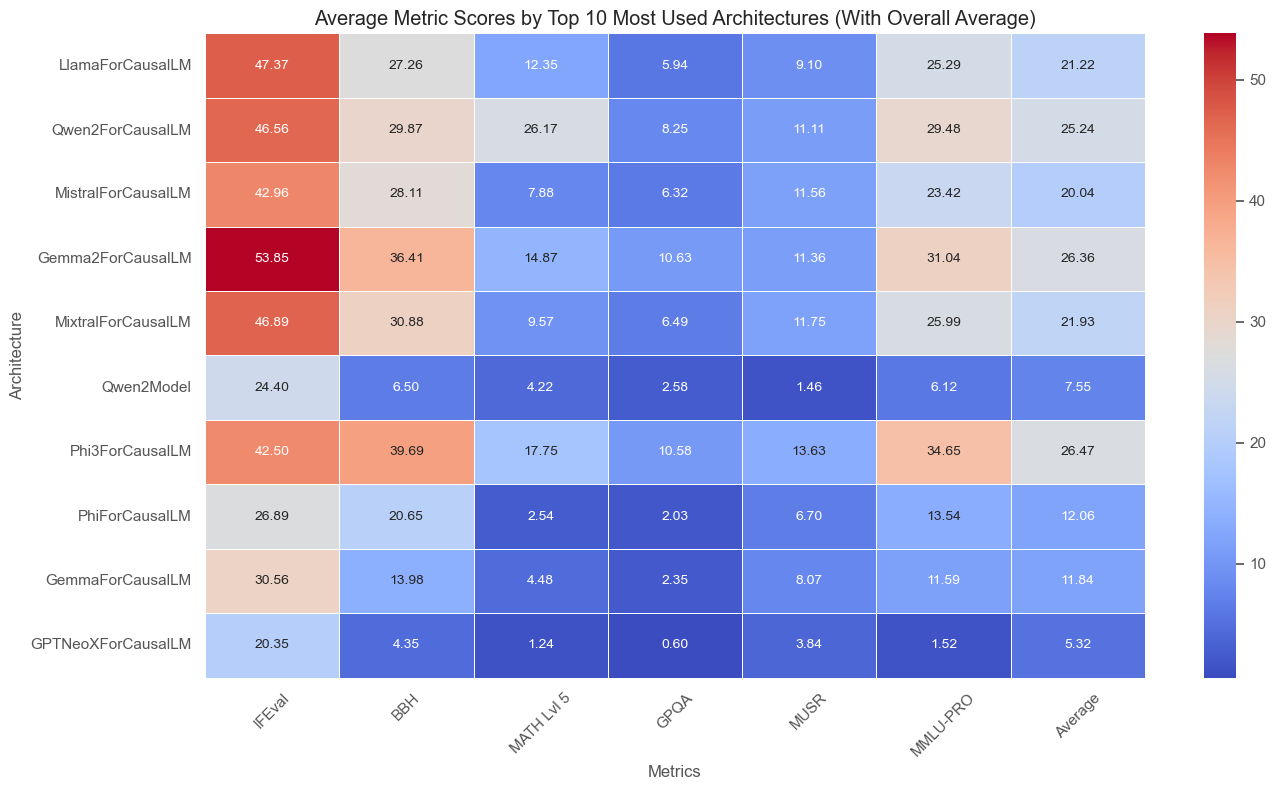

In [83]:
mean_performance_top10_arch_ordered['Average'] = mean_performance_top10_arch_ordered.mean(axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(mean_performance_top10_arch_ordered, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Average Metric Scores by Top 10 Most Used Architectures (With Overall Average)")
plt.xlabel("Metrics")
plt.ylabel("Architecture")
plt.tight_layout()
plt.show()



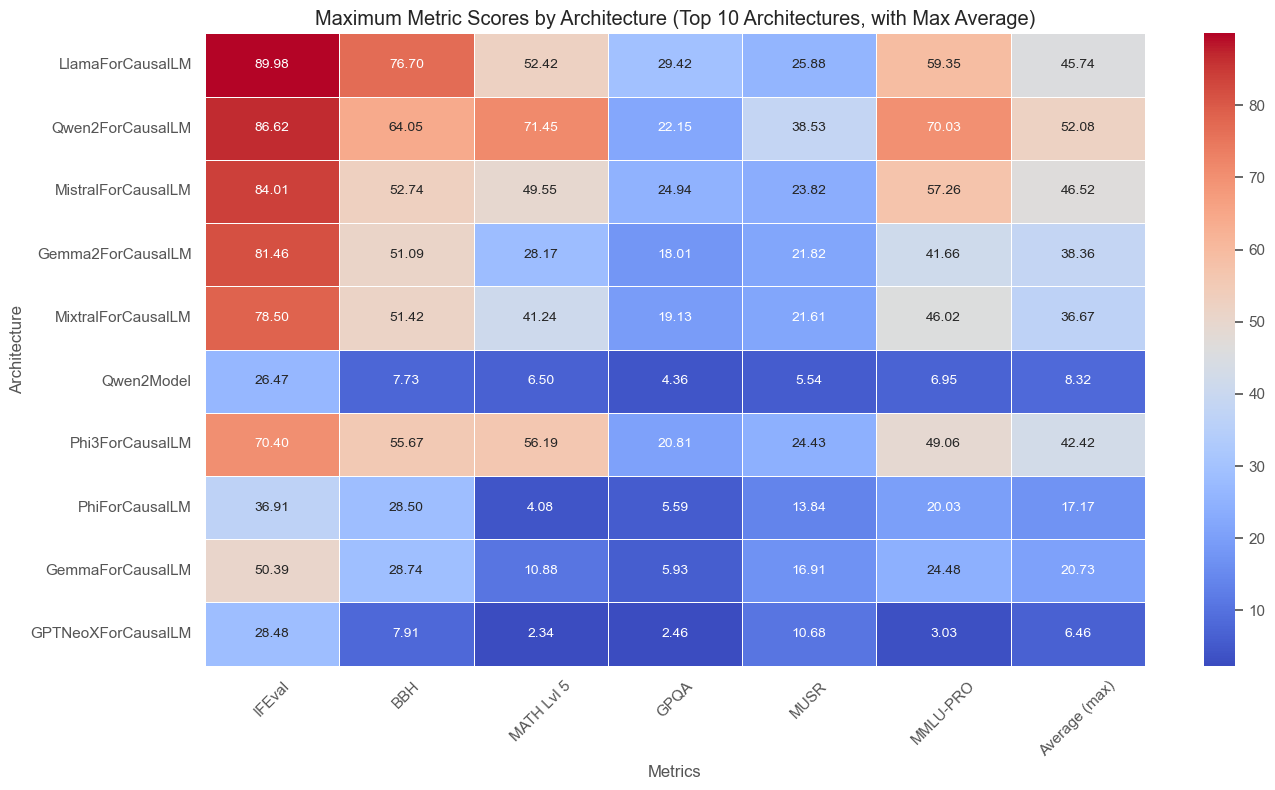

In [84]:
max_scores_by_arch = df_nonzero_params[df_nonzero_params["Architecture"].isin(top_10_architectures_ordered)].groupby('Architecture')[metrics].max()

max_average_scores = df_nonzero_params.groupby('Architecture')['Average ⬆️'].max()

max_metrics_by_arch = pd.DataFrame(
    {arch: df_nonzero_params[df_nonzero_params['Architecture'] == arch][metrics].max() 
     for arch in top_10_architectures_ordered}
).T

max_avg_score = df_nonzero_params.groupby('Architecture')['Average ⬆️'].max()

max_metrics_by_arch['Average (max)'] = max_average_scores[top_10_architectures_ordered]

max_metrics_by_arch = max_metrics_by_arch.loc[top_10_architectures_ordered]

plt.figure(figsize=(14, 8))
sns.heatmap(max_metrics_by_arch, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Maximum Metric Scores by Architecture (Top 10 Architectures, with Max Average)")
plt.xlabel("Metrics")
plt.ylabel("Architecture")
plt.tight_layout()
plt.show()


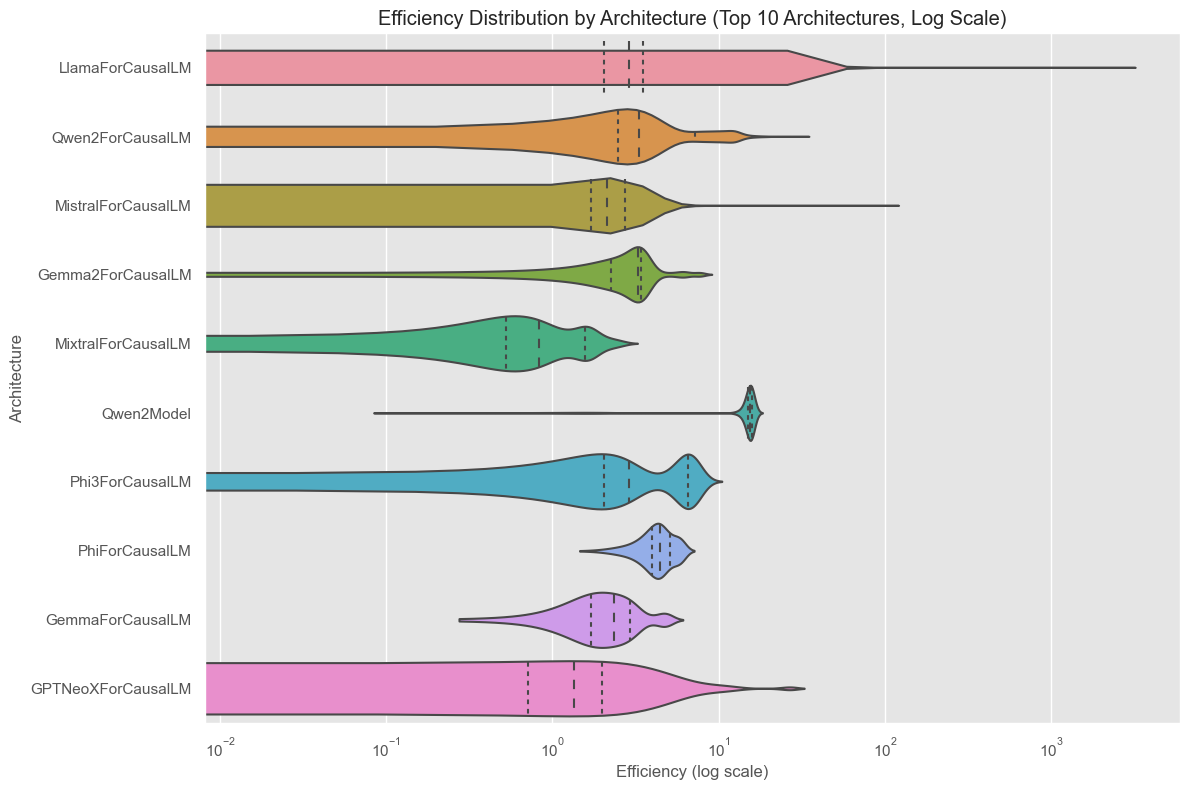

In [85]:
df_top10_arch_efficiency = df_nonzero_params[df_nonzero_params["Architecture"].isin(top_10_architectures_ordered)].copy()

df_top10_arch_efficiency["Architecture"] = pd.Categorical(
    df_top10_arch_efficiency["Architecture"],
    categories=top_10_architectures_ordered,
    ordered=True
)

df_top10_arch_efficiency["Efficiency"] = df_top10_arch_efficiency["Average ⬆️"] / df_top10_arch_efficiency["#Params (B)"]

plt.figure(figsize=(12, 8))
sns.violinplot(data=df_top10_arch_efficiency, 
               y='Architecture', 
               x='Efficiency', 
               scale='width', 
               inner='quartile')

plt.xscale('log')  
plt.title("Efficiency Distribution by Architecture (Top 10 Architectures, Log Scale)")
plt.xlabel("Efficiency (log scale)")
plt.ylabel("Architecture")
plt.tight_layout()
plt.show()



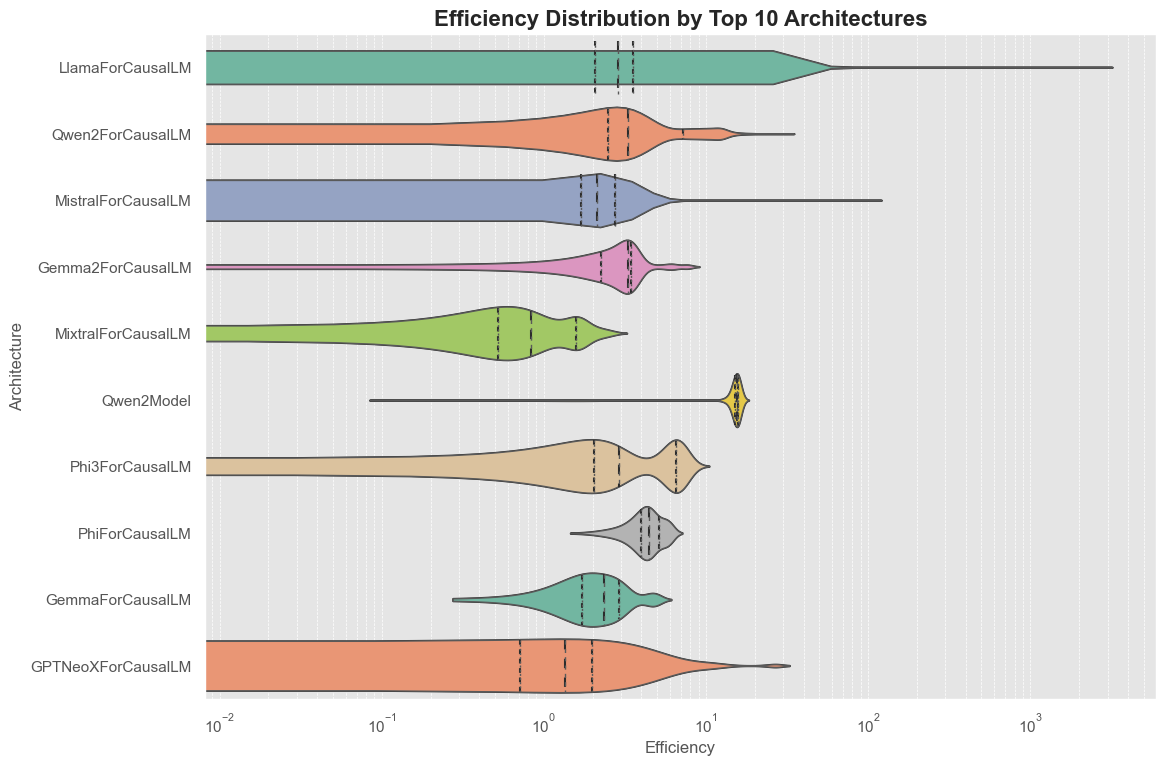

In [86]:
plt.figure(figsize=(12, 8))

sns.violinplot(
    data=df_top10_arch_efficiency,
    y='Architecture', 
    x='Efficiency',
    palette='viridis',
    scale='width',
    inner='quartile'
)

plt.xscale('log')

plt.title("Efficiency Distribution by Top 10 Architectures", fontsize=16, fontweight='bold')
plt.xlabel("Efficiency (Average ⬆️ / #Params (B), log scale)", fontsize=12)
plt.ylabel("Architecture", fontsize=12)

sns.set(style="whitegrid", context='talk')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

sns.violinplot(
    data=df_top10_arch_efficiency, 
    y='Architecture', 
    x='Efficiency', 
    palette='Set2', 
    inner='quartile', 
    linewidth=1,
    scale='width'
)

plt.tight_layout()
plt.show()


# Non Temporal Trends - Part2

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
# load data_4072.json to pandas dataframe
df = pd.read_json('data_4072.json', orient='records')

# overall analysis
df['Average ⬆️'] = pd.to_numeric(df['Average ⬆️'], errors='coerce')
df['CO₂ cost (kg)'] = pd.to_numeric(df['CO₂ cost (kg)'], errors='coerce')
df['#Params (B)'] = pd.to_numeric(df['#Params (B)'], errors='coerce')

highest_avg_row = df.loc[df['Average ⬆️'].idxmax()]
lowest_co2_row = df.loc[df['CO₂ cost (kg)'].idxmin()]
lowest_params_row = df.loc[df['#Params (B)'].idxmin()]

df_eff = df[(df['CO₂ cost (kg)'] != 0) & (df['#Params (B)'] != 0) & (df['#Params (B)'] != -1)]

df_eff = df_eff.copy() 
df_eff['carbon_efficiency'] = df_eff['Average ⬆️'] / df_eff['CO₂ cost (kg)']
df_eff['param_efficiency'] = df_eff['Average ⬆️'] / df_eff['#Params (B)']

highest_co2_eff_row = df_eff.loc[df_eff['carbon_efficiency'].idxmax()]
highest_param_eff_row = df_eff.loc[df_eff['param_efficiency'].idxmax()]

# get all column names of panda dataframe
columns = df.columns.tolist()

In [88]:
arch_counts = df['Architecture'].value_counts()
top_archs = arch_counts.nlargest(5)
# filter '?'
top_archs = top_archs[top_archs.index != "?"]
top_archs_list = top_archs.index.tolist()

top_archs_df = df[df['Architecture'].isin(top_archs.index)]

df_top = df[df['Architecture'].isin(top_archs_list)].copy()

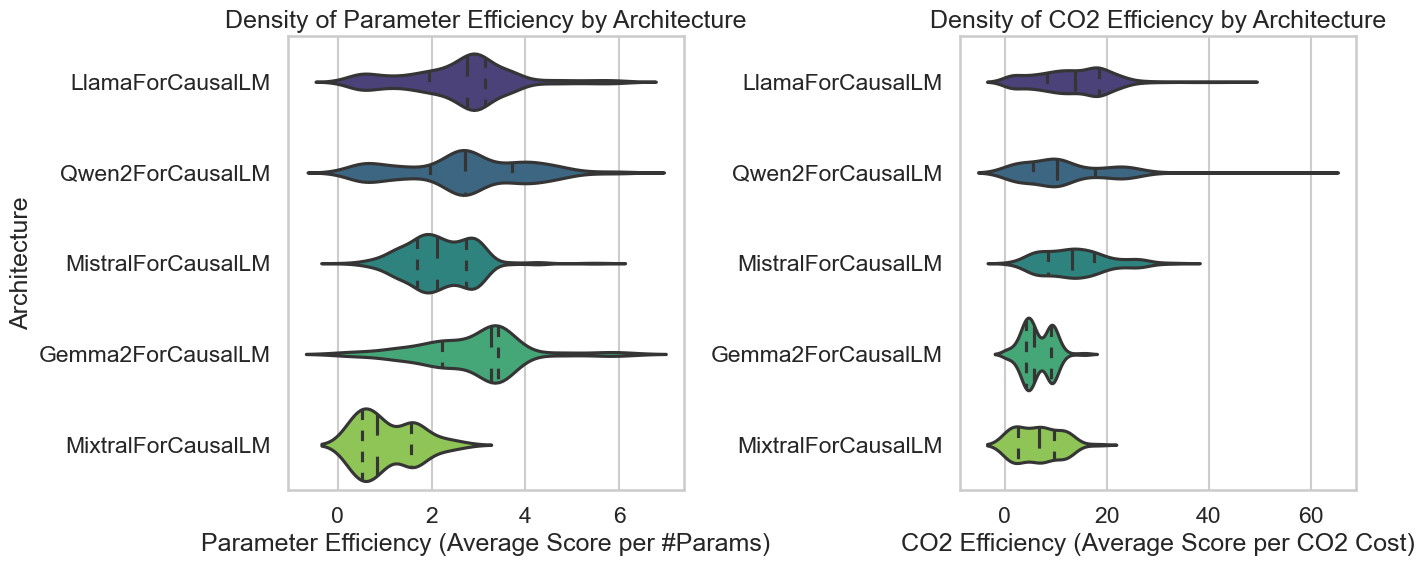

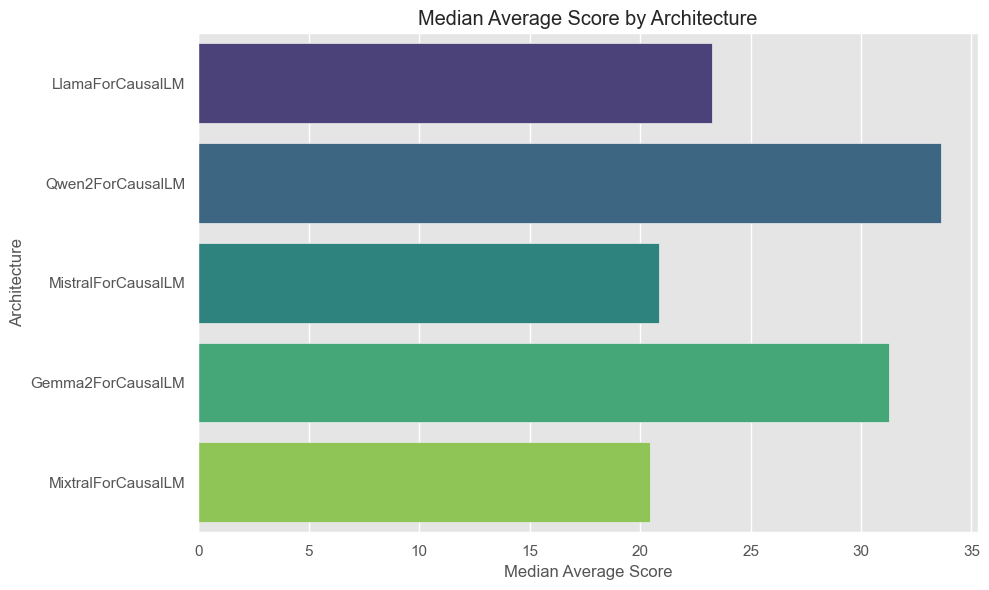

In [89]:
numeric_cols = ['#Params (B)', 'CO₂ cost (kg)']
for col in numeric_cols:
    df_top[col] = pd.to_numeric(df_top[col], errors='coerce')
    
param_median = df_top.groupby('Architecture')['#Params (B)'].median().reindex(top_archs_list)

co2_median = df_top.groupby('Architecture')['CO₂ cost (kg)'].median().reindex(top_archs_list)

top_archs_list = top_archs.index.tolist()
df_top = df[df['Architecture'].isin(top_archs_list)].copy()

numeric_cols = ['#Params (B)', 'CO₂ cost (kg)', 'Average ⬆️']
for col in numeric_cols:
    df_top[col] = pd.to_numeric(df_top[col], errors='coerce')
    
df_top = df_top[df_top['#Params (B)'] != 0]

# Parameter Efficiency: Average Score per Parameter
df_top['param_efficiency'] = df_top['Average ⬆️'] / df_top['#Params (B)']

# CO2 Emission Efficiency: Average Score per CO₂ cost
df_top['co2_efficiency'] = df_top['Average ⬆️'] / df_top['CO₂ cost (kg)']

df_top = df_top[(df_top['param_efficiency'] >= 0) & (df_top['co2_efficiency'] >= 0)]

Q1 = df_top['param_efficiency'].quantile(0.25)
Q3 = df_top['param_efficiency'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

df_top = df_top[df_top['param_efficiency'] <= upper_bound]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(ax=axes[0], x='param_efficiency', y='Architecture', data=df_top, order=top_archs_list, 
               palette='viridis', inner='quartile')
axes[0].set_title('Density of Parameter Efficiency by Architecture')
axes[0].set_xlabel('Parameter Efficiency (Average Score per #Params)')
axes[0].set_ylabel('Architecture')

sns.violinplot(ax=axes[1], x='co2_efficiency', y='Architecture', data=df_top, order=top_archs_list, 
               palette='viridis', inner='quartile')
axes[1].set_title('Density of CO2 Efficiency by Architecture')
axes[1].set_xlabel('CO2 Efficiency (Average Score per CO2 Cost)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('violin2.png', dpi=300, bbox_inches='tight')
plt.show()

sns.set_theme(style="whitegrid")

avg_median = df_top.groupby('Architecture')['Average ⬆️'].median().reindex(top_archs_list)

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_median.values, y=avg_median.index, palette='viridis')
plt.title('Median Average Score by Architecture')
plt.xlabel('Median Average Score')
plt.ylabel('Architecture')
plt.tight_layout()
plt.savefig('median_average_by_architecture.png', dpi=300, bbox_inches='tight')
plt.show()

# Temporal Trends

#Load and Preprocess data

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Login using e.g. `huggingface-cli login` to access this dataset
# df = pd.read_json("https://raw.githubusercontent.com/jasonli35/LLM_Data_Analysis/refs/heads/master/data_4072.json")
df = pd.read_json("data_4072.json")

to_drop = [
    'eval_name', 'Type', 'Weight type', 'Model sha', 'Hub License',
    'Available on the hub', 'MoE', 'Chat Template', 'Merged', 'Official Providers',
    'Model'
]

df = df[df['Flagged'] != True]
df = df[df['Architecture'] != '?']
score_drop = [col for col in df.columns if "Raw" in col]
df = df.drop(columns= score_drop + to_drop)
df = df.drop(columns='Flagged')

df['Submission Date'] = pd.to_datetime(df['Submission Date'], format='%Y-%m-%d')
df['Upload To Hub Date'] = pd.to_datetime(df['Upload To Hub Date'], format='%Y-%m-%d')
df = df.dropna(subset=['Submission Date'])

df.loc[:,'Upload_Submission_Diff'] = (df['Submission Date'] - df['Upload To Hub Date']).dt.days

stats = df['Upload_Submission_Diff'].describe()
print(stats)

na_upload = df['Upload To Hub Date'].isna().sum()
na_submission = df['Submission Date'].isna().sum()

print(f"NA in Upload To Hub Date: {na_upload}")
print(f"NA in Submission Date: {na_submission}")

# Temporal Filter
df = df.sort_values('Submission Date')
df['Submission Week'] = df['Submission Date'] - pd.to_timedelta(df['Submission Date'].dt.weekday, unit='D')
df['Submission Month'] = df['Submission Date'].dt.strftime('%B %Y')
df['Formatted Month'] = df['Submission Date'].dt.strftime('%b %Y')
df['Formatted Week'] = df['Submission Week'].dt.strftime('%b %d, %Y')

count    3632.000000
mean       42.237059
std       106.454735
min       -29.000000
25%         0.000000
50%         2.000000
75%        28.000000
max       919.000000
Name: Upload_Submission_Diff, dtype: float64
NA in Upload To Hub Date: 379
NA in Submission Date: 0


Set a clear darkgrid theme for plots

In [91]:
sns.set_theme()

# Submission Counts Trend

Weekly

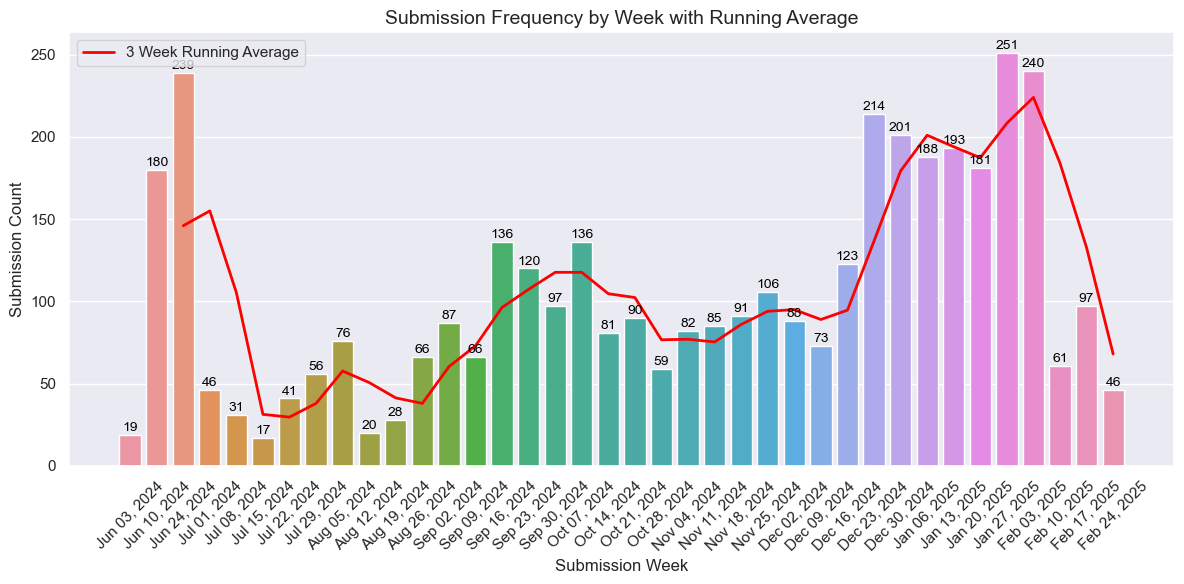

In [92]:
# Ensure 'Submission Week' is a datetime object
df['Submission Week'] = pd.to_datetime(df['Submission Week'], format='%Y-%m-%d')

# Group by Submission Week and count the submissions
submission_week_counts = df.groupby('Submission Week').size().reset_index(name='Submission Count')

# Sort by Submission Week (chronologically)
submission_week_counts = submission_week_counts.sort_values('Submission Week')

# Calculate the 7-day rolling average for Submission Count
submission_week_counts['Rolling Average'] = submission_week_counts['Submission Count'].rolling(window=3).mean()

# Convert 'Submission Week' to formatted string (Week Start Date)
submission_week_counts['Formatted Week'] = submission_week_counts['Submission Week'].dt.strftime('%b %d, %Y')

# Create the Seaborn bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Formatted Week', y='Submission Count', data=submission_week_counts,
                  )

# Add annotations above each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Plot the running average line (rolling mean)
ax.plot(submission_week_counts['Formatted Week'], submission_week_counts['Rolling Average'], color='red', label='3 Week Running Average', lw=2)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Submission Week', fontsize=12)
plt.ylabel('Submission Count', fontsize=12)
plt.title('Submission Frequency by Week with Running Average', fontsize=14)

# Show the plot
plt.tight_layout()
plt.legend()
plt.show()


# Score Trend

Monthly

/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0, flags=flags)


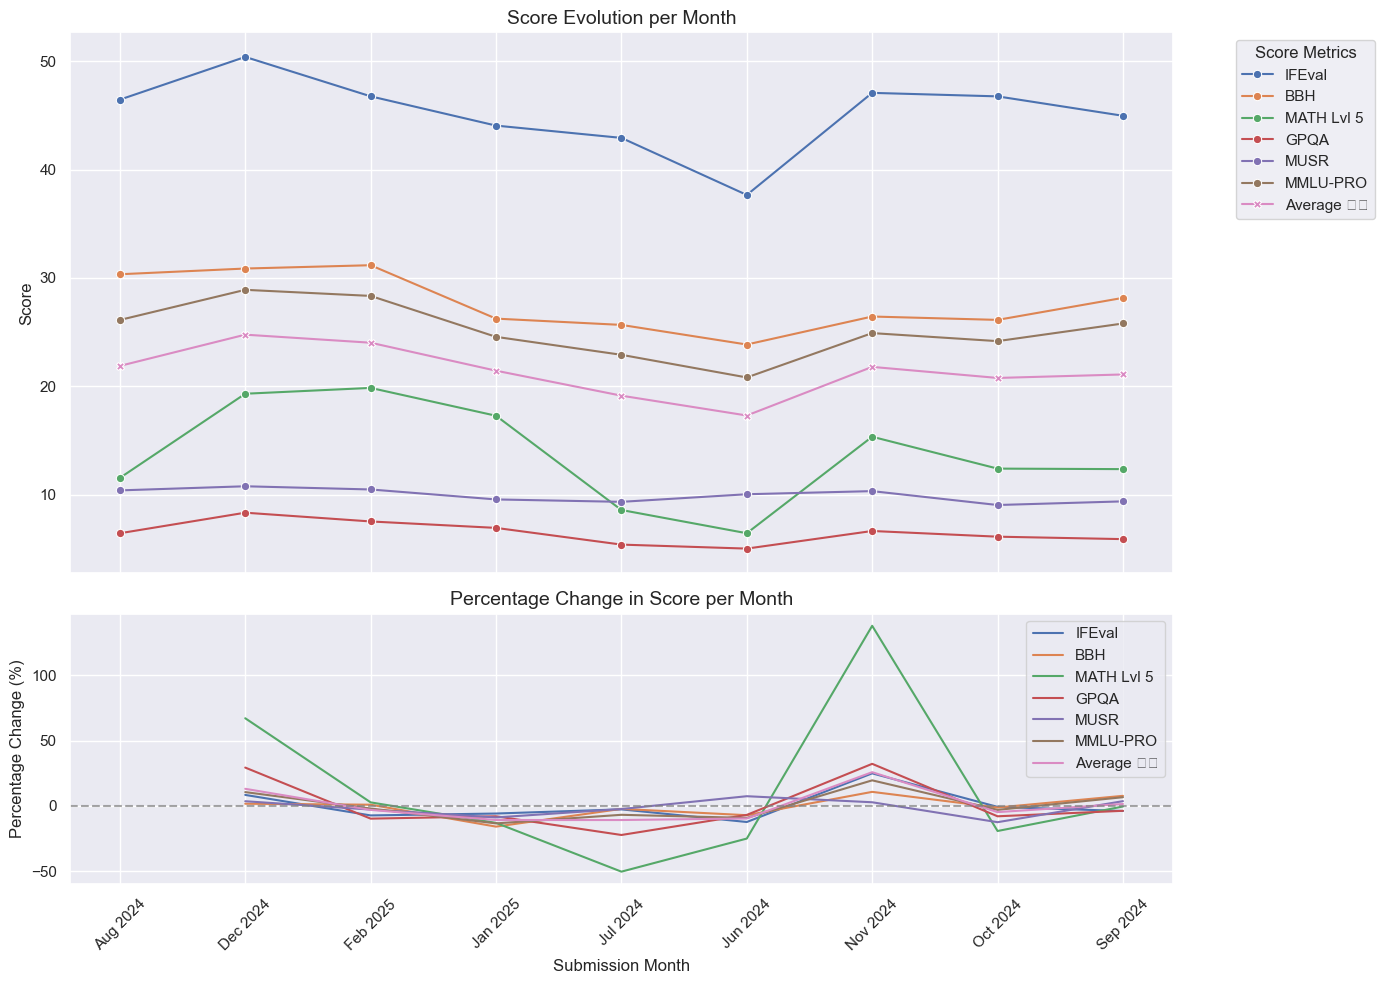

In [93]:
# Define score metrics
score_metrics = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO', 'Average ⬆️']

# Group by 'Submission Month' and calculate mean scores
monthly_avg = df.groupby(['Submission Month', 'Formatted Month'])[score_metrics].mean().reset_index()

# Sort by 'Submission Month' to ensure temporal order
monthly_avg = monthly_avg.sort_values('Submission Month')

# Compute percentage change
monthly_avg_pct = monthly_avg.copy()
monthly_avg_pct[score_metrics] = monthly_avg[score_metrics].pct_change() * 100  # Convert to %

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- Top Plot: Score Evolution ---
for metric in score_metrics:
    mark = 'X' if metric == 'Average ⬆️' else 'o'
    sns.lineplot(x='Formatted Month', y=metric, data=monthly_avg, label=metric, marker=mark, ax=axes[0])

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Score Evolution per Month', fontsize=14)
axes[0].legend(title='Score Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Bottom Plot: Percentage Change ---
for metric in score_metrics:
    sns.lineplot(x='Formatted Month', y=metric, data=monthly_avg_pct, label=metric, ax=axes[1])

axes[1].set_ylabel('Percentage Change (%)', fontsize=12)
axes[1].set_xlabel('Submission Month', fontsize=12)
axes[1].set_title('Percentage Change in Score per Month', fontsize=14)
axes[1].axhline(0, linestyle='--', color='gray', alpha=0.7)  # Baseline at 0% change

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plots
plt.show()

/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0, flags=flags)


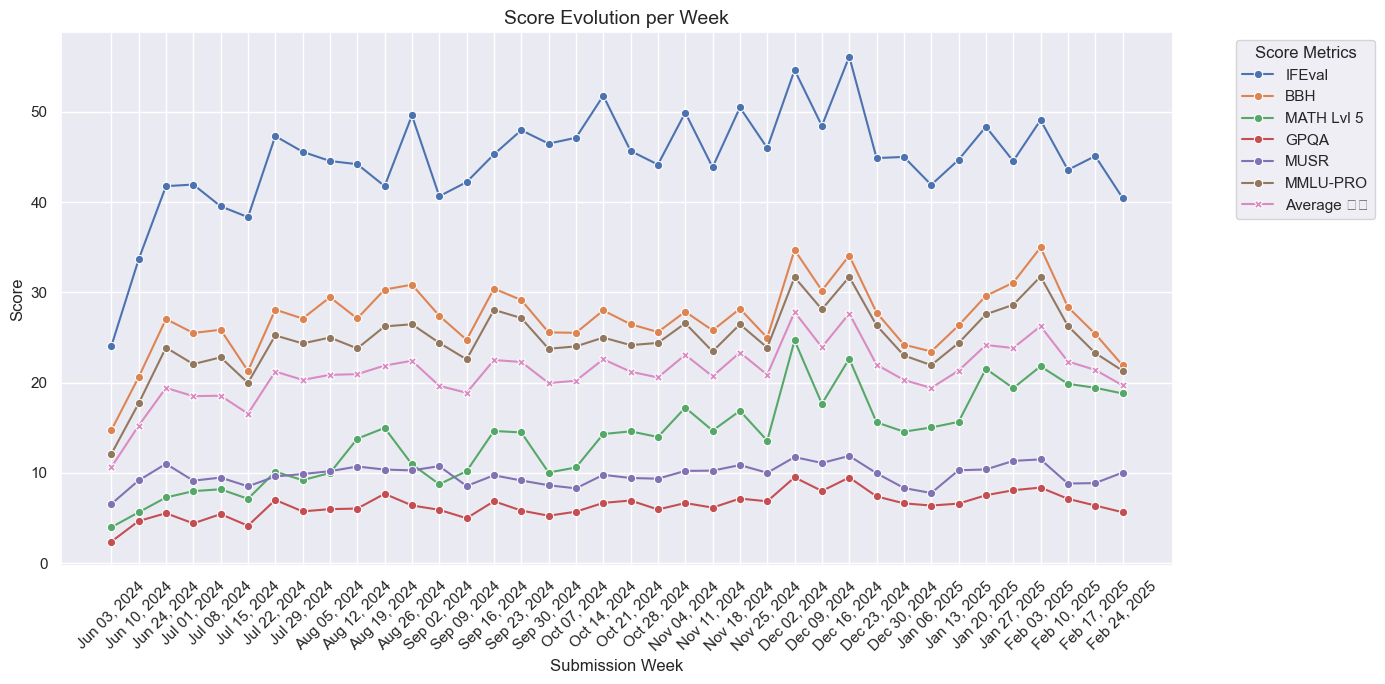

In [94]:
# Define score metrics
score_metrics = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO', 'Average ⬆️']

# Group by 'Submission Week' and calculate mean scores
weekly_avg = df.groupby(['Submission Week', 'Formatted Week'])[score_metrics].mean().reset_index()

# Sort by 'Submission Week' to ensure temporal order
weekly_avg = weekly_avg.sort_values('Submission Week')

# Create the plot
plt.figure(figsize=(14, 7))

# Plot score evolution for each metric
for metric in score_metrics:
    mark = 'X' if metric == 'Average ⬆️' else 'o'
    sns.lineplot(x='Formatted Week', y=metric, data=weekly_avg, label=metric, marker=mark)

# Labels and title
plt.ylabel('Score', fontsize=12)
plt.xlabel('Submission Week', fontsize=12)
plt.title('Score Evolution per Week', fontsize=14)

# Add legend
plt.legend(title='Score Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Weekly

/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0, flags=flags)


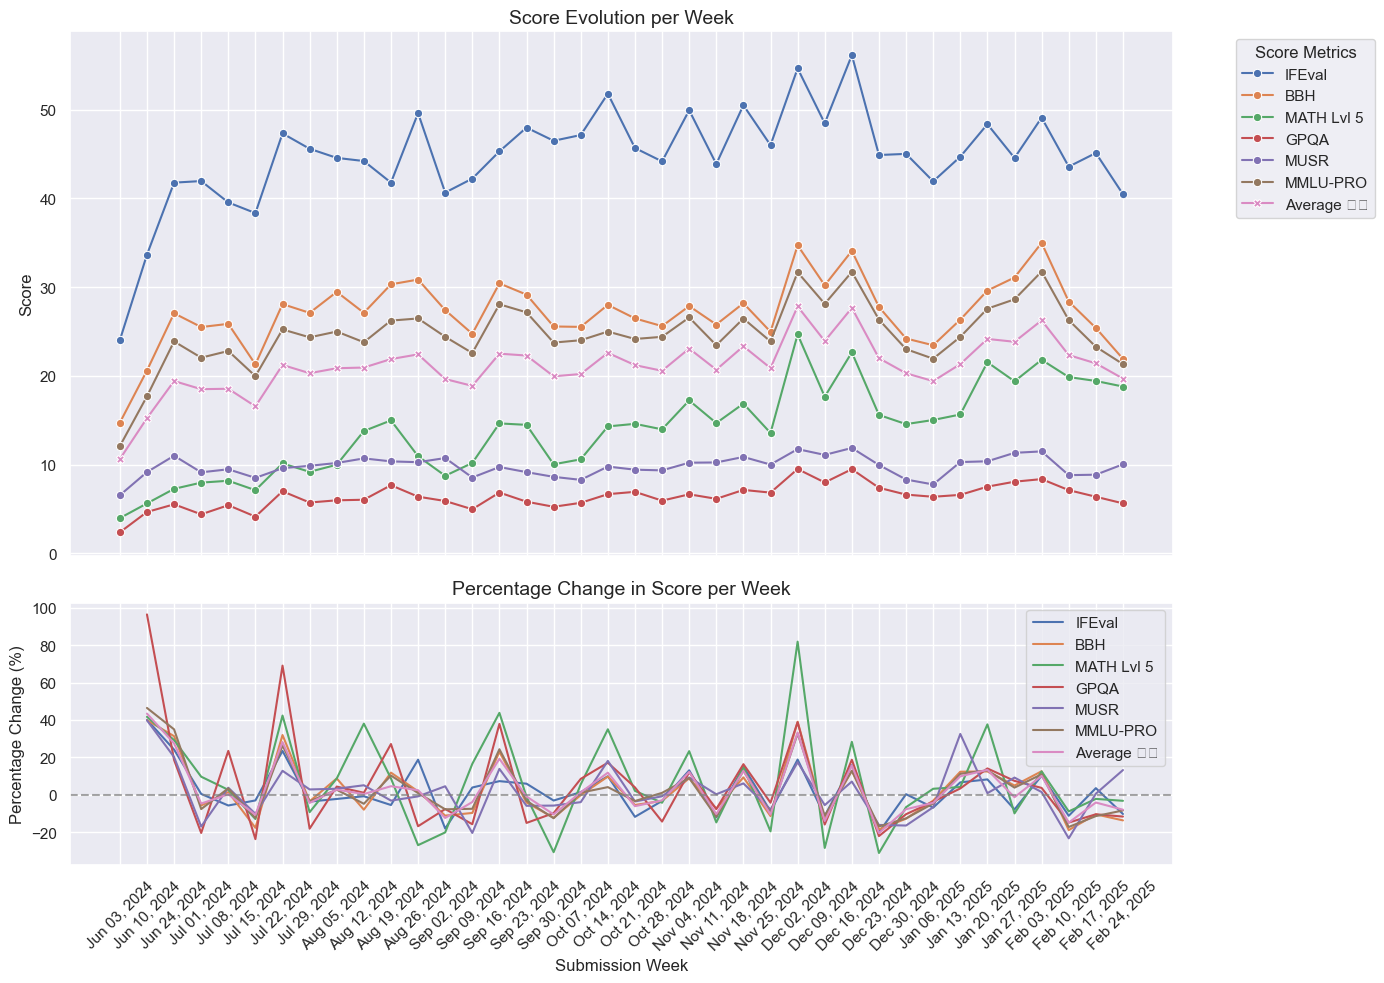

In [95]:
# Define score metrics
score_metrics = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO', 'Average ⬆️']

# Group by 'Submission Week' and calculate mean scores
weekly_avg = df.groupby(['Submission Week', 'Formatted Week'])[score_metrics].mean().reset_index()

# Sort by 'Submission Week' to ensure temporal order
weekly_avg = weekly_avg.sort_values('Submission Week')

# Compute percentage change
weekly_avg_pct = weekly_avg.copy()
weekly_avg_pct[score_metrics] = weekly_avg[score_metrics].pct_change() * 100  # Convert to %

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- Top Plot: Score Evolution ---
for metric in score_metrics:
    mark = 'X' if metric == 'Average ⬆️' else 'o'
    sns.lineplot(x='Formatted Week', y=metric, data=weekly_avg, label=metric, marker=mark, ax=axes[0])

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Score Evolution per Week', fontsize=14)
axes[0].legend(title='Score Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Bottom Plot: Percentage Change ---
for metric in score_metrics:
    sns.lineplot(x='Formatted Week', y=metric, data=weekly_avg_pct, label=metric, ax=axes[1])

axes[1].set_ylabel('Percentage Change (%)', fontsize=12)
axes[1].set_xlabel('Submission Week', fontsize=12)
axes[1].set_title('Percentage Change in Score per Week', fontsize=14)
axes[1].axhline(0, linestyle='--', color='gray', alpha=0.7)  # Baseline at 0% change

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plots
plt.show()

# CO2 Cost Trend

Monthly

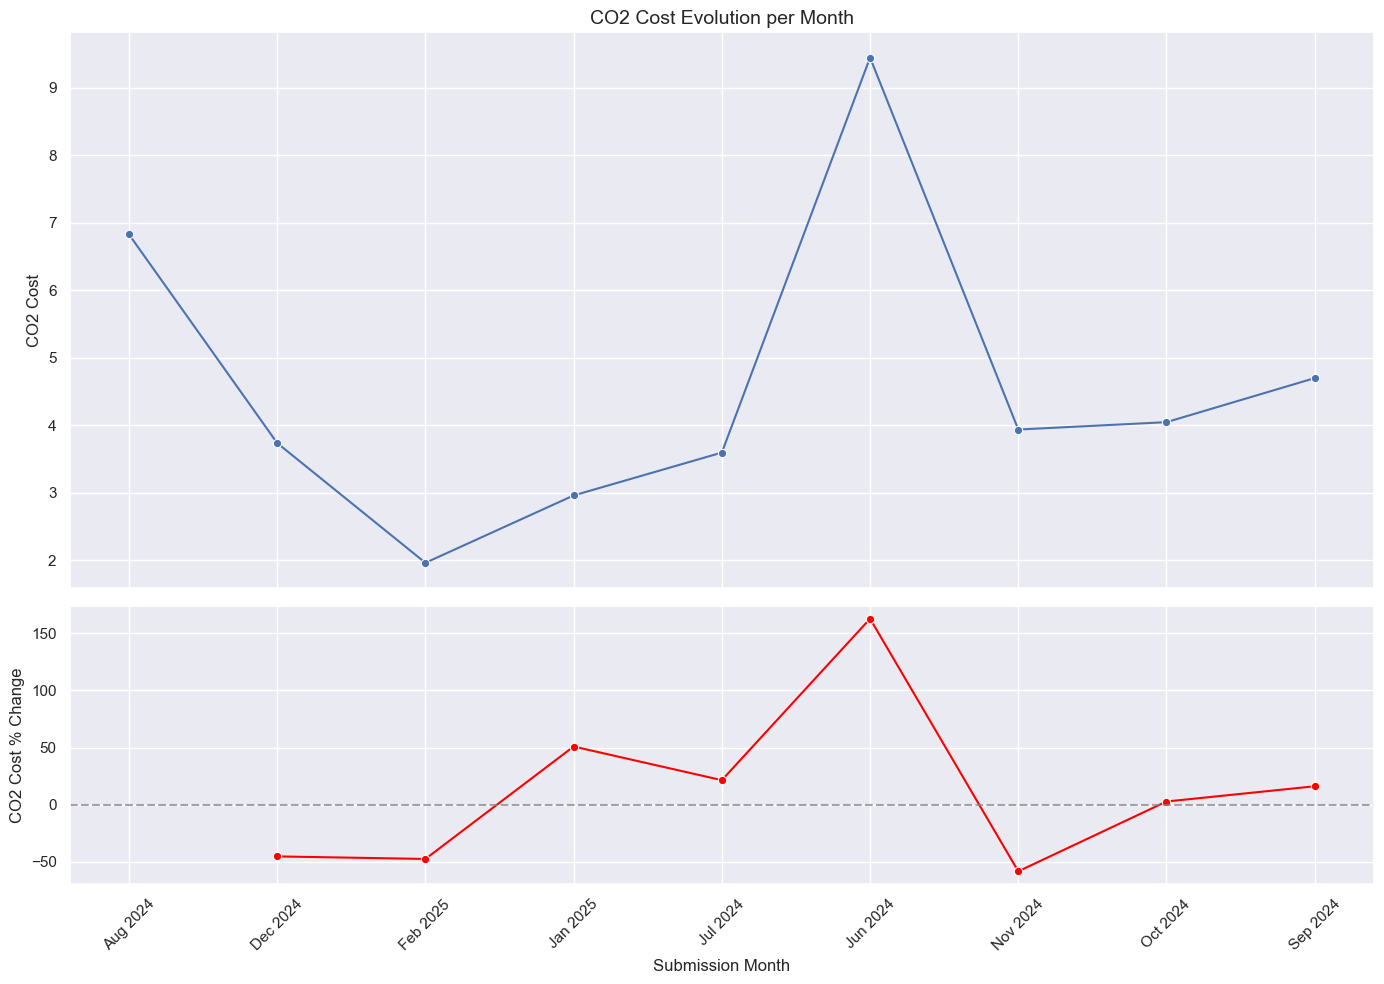

In [96]:
# Group by 'Submission Month' and calculate mean CO2 cost
monthly_co2 = df.groupby(['Submission Month', 'Formatted Month'])['CO₂ cost (kg)'].mean().reset_index()

# Sort by 'Submission Month' to ensure temporal order
monthly_co2 = monthly_co2.sort_values('Submission Month')

# Calculate percentage change
monthly_co2['CO2 Cost % Change'] = monthly_co2['CO₂ cost (kg)'].pct_change() * 100

# Create a dual-plot figure
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Top plot: CO2 cost over time
sns.lineplot(x='Formatted Month', y='CO₂ cost (kg)', data=monthly_co2, marker='o', ax=ax[0])
ax[0].set_ylabel('CO2 Cost', fontsize=12)
ax[0].set_title('CO2 Cost Evolution per Month', fontsize=14)

# Bottom plot: Percentage change in CO2 cost
sns.lineplot(x='Formatted Month', y='CO2 Cost % Change', data=monthly_co2, marker='o', ax=ax[1], color='red')
ax[1].axhline(0, linestyle='--', color='gray', alpha=0.7)
ax[1].set_ylabel('CO2 Cost % Change', fontsize=12)
ax[1].set_xlabel('Submission Month', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Weekly

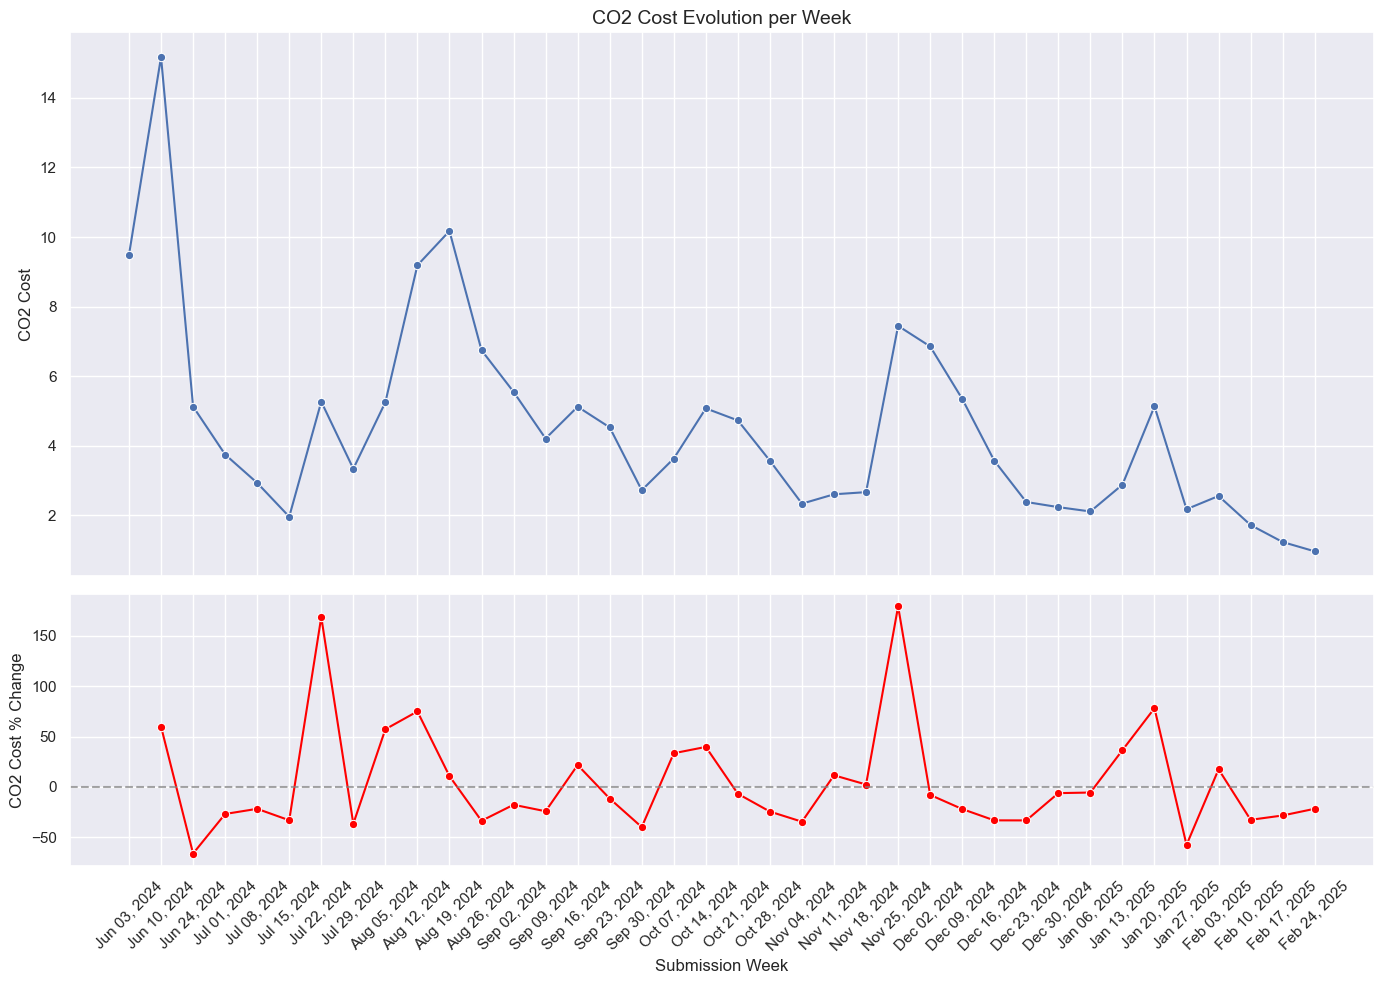

In [97]:
# Group by 'Submission Week' and calculate mean CO2 cost
weekly_co2 = df.groupby(['Submission Week', 'Formatted Week'])['CO₂ cost (kg)'].mean().reset_index()

# Sort by 'Submission Week' to ensure temporal order
weekly_co2 = weekly_co2.sort_values('Submission Week')

# Calculate percentage change
weekly_co2['CO2 Cost % Change'] = weekly_co2['CO₂ cost (kg)'].pct_change() * 100

# Create a dual-plot figure
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Top plot: CO2 cost over time
sns.lineplot(x='Formatted Week', y='CO₂ cost (kg)', data=weekly_co2, marker='o', ax=ax[0])
ax[0].set_ylabel('CO2 Cost', fontsize=12)
ax[0].set_title('CO2 Cost Evolution per Week', fontsize=14)

# Bottom plot: Percentage change in CO2 cost
sns.lineplot(x='Formatted Week', y='CO2 Cost % Change', data=weekly_co2, marker='o', ax=ax[1], color='red')
ax[1].axhline(0, linestyle='--', color='gray', alpha=0.7)
ax[1].set_ylabel('CO2 Cost % Change', fontsize=12)
ax[1].set_xlabel('Submission Week', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Parameter Trend

Monthly

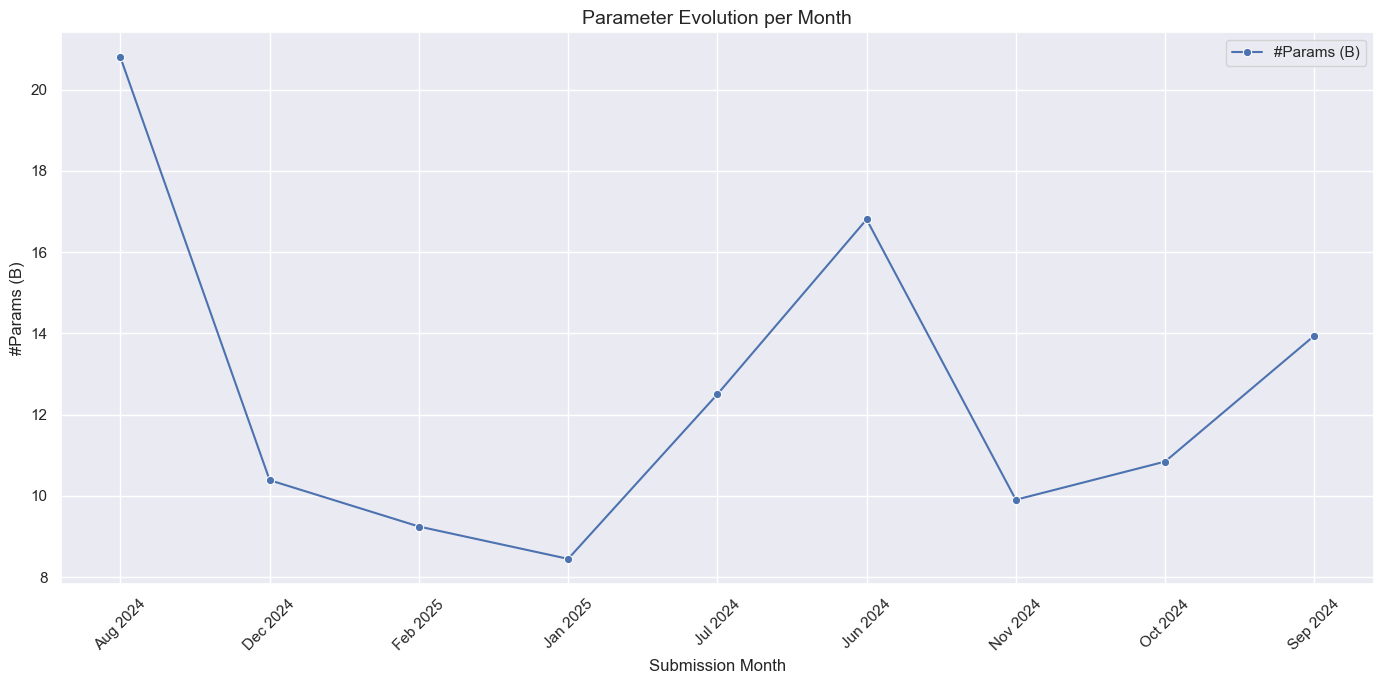

In [98]:
# Group by 'Submission Month' and calculate mean #Params (B)
monthly_params = df.groupby(['Submission Month', 'Formatted Month'])['#Params (B)'].mean().reset_index()

# Sort by 'Submission Month' to ensure temporal order
monthly_params = monthly_params.sort_values('Submission Month')

# Create the plot
plt.figure(figsize=(14, 7))

# Plot #Params (B) evolution
sns.lineplot(x='Formatted Month', y='#Params (B)', data=monthly_params, marker='o', label='#Params (B)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Submission Month', fontsize=12)
plt.ylabel('#Params (B)', fontsize=12)
plt.title('Parameter Evolution per Month', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

Weekly

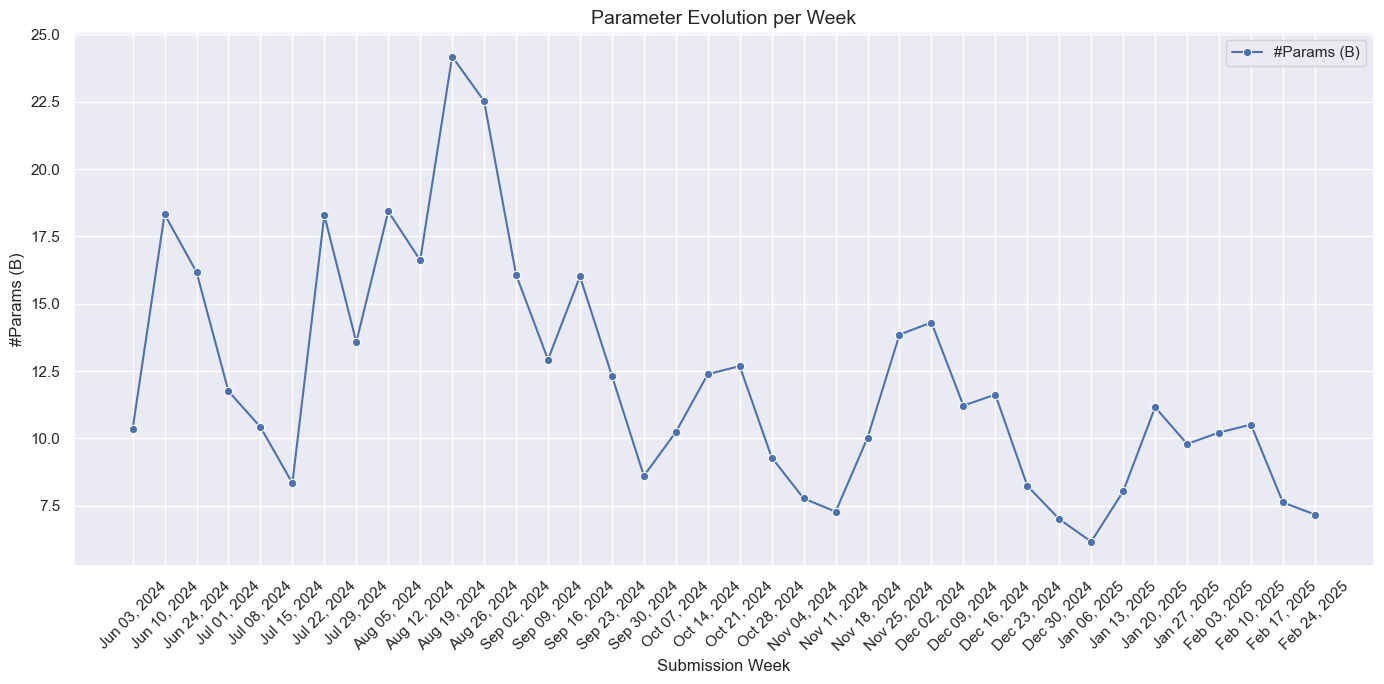

In [99]:
# Group by 'Submission Week' and calculate mean #Params (B)
weekly_params = df.groupby(['Submission Week', 'Formatted Week'])['#Params (B)'].mean().reset_index()

# Sort by 'Submission Week' to ensure temporal order
weekly_params = weekly_params.sort_values('Submission Week')

# Create the plot
plt.figure(figsize=(14, 7))

# Plot #Params (B) evolution
sns.lineplot(x='Formatted Week', y='#Params (B)', data=weekly_params, marker='o', label='#Params (B)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Submission Week', fontsize=12)
plt.ylabel('#Params (B)', fontsize=12)
plt.title('Parameter Evolution per Week', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

# CO2 and Parameter

Dual Plot - Weekly

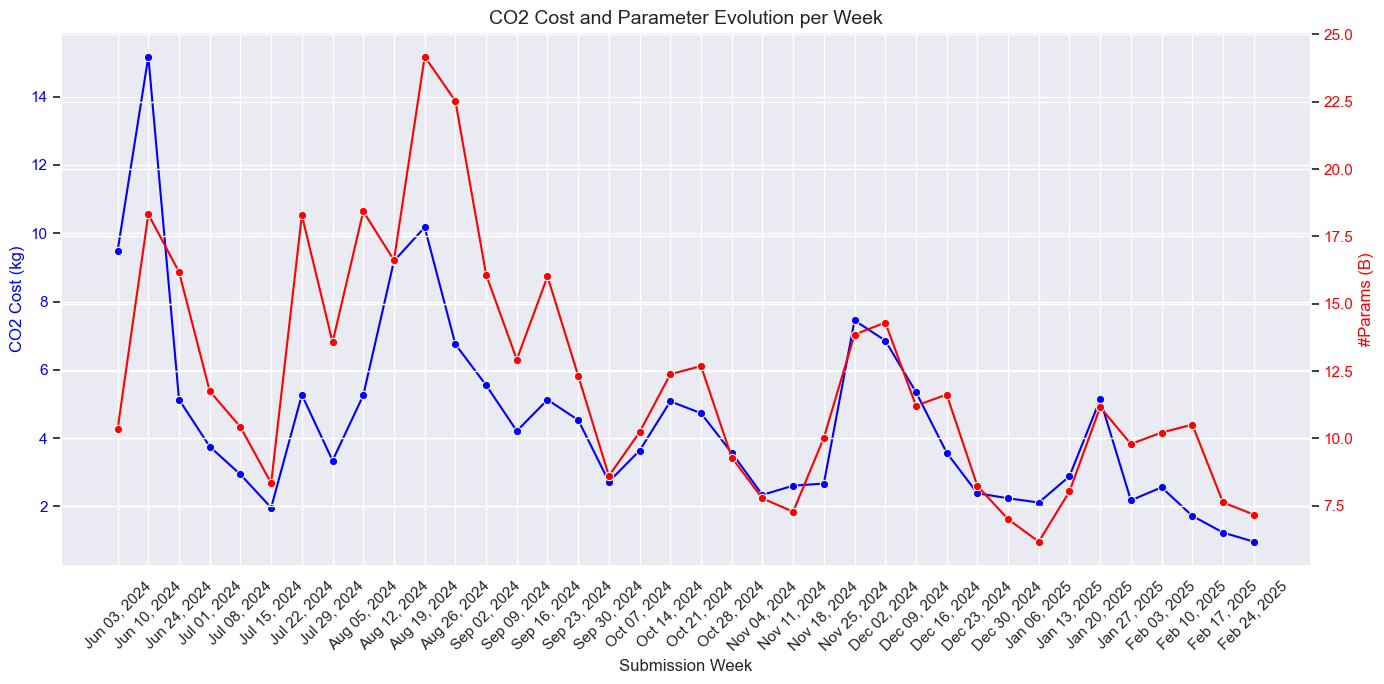

In [100]:
# Group by 'Submission Week' and calculate mean CO2 cost
weekly_co2 = df.groupby(['Submission Week', 'Formatted Week'])['CO₂ cost (kg)'].mean().reset_index()

# Sort by 'Submission Week' to ensure temporal order
weekly_co2 = weekly_co2.sort_values('Submission Week')

# Calculate percentage change
weekly_co2['CO2 Cost % Change'] = weekly_co2['CO₂ cost (kg)'].pct_change() * 100

# Group by 'Submission Week' and calculate mean #Params (B)
weekly_params = df.groupby(['Submission Week', 'Formatted Week'])['#Params (B)'].mean().reset_index()

# Sort by 'Submission Week' to ensure temporal order
weekly_params = weekly_params.sort_values('Submission Week')

# Create the dual y-axis plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot CO2 cost on the left y-axis
sns.lineplot(x='Formatted Week', y='CO₂ cost (kg)', data=weekly_co2, marker='o', ax=ax1, color='blue')
ax1.set_ylabel('CO2 Cost (kg)', fontsize=12, color='blue')
ax1.set_title('CO2 Cost and Parameter Evolution per Week', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=45)

# Create a second y-axis for parameters
ax2 = ax1.twinx()

# Plot #Params (B) on the right y-axis
sns.lineplot(x='Formatted Week', y='#Params (B)', data=weekly_params, marker='o', ax=ax2, color='red')
ax2.set_ylabel('#Params (B)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')


# Add labels and adjust layout
ax1.set_xlabel('Submission Week', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

# Score, CO2 and Parameter

Two Panel plot - Score and Dual plot - Weekly

/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 11014 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/yifan/de

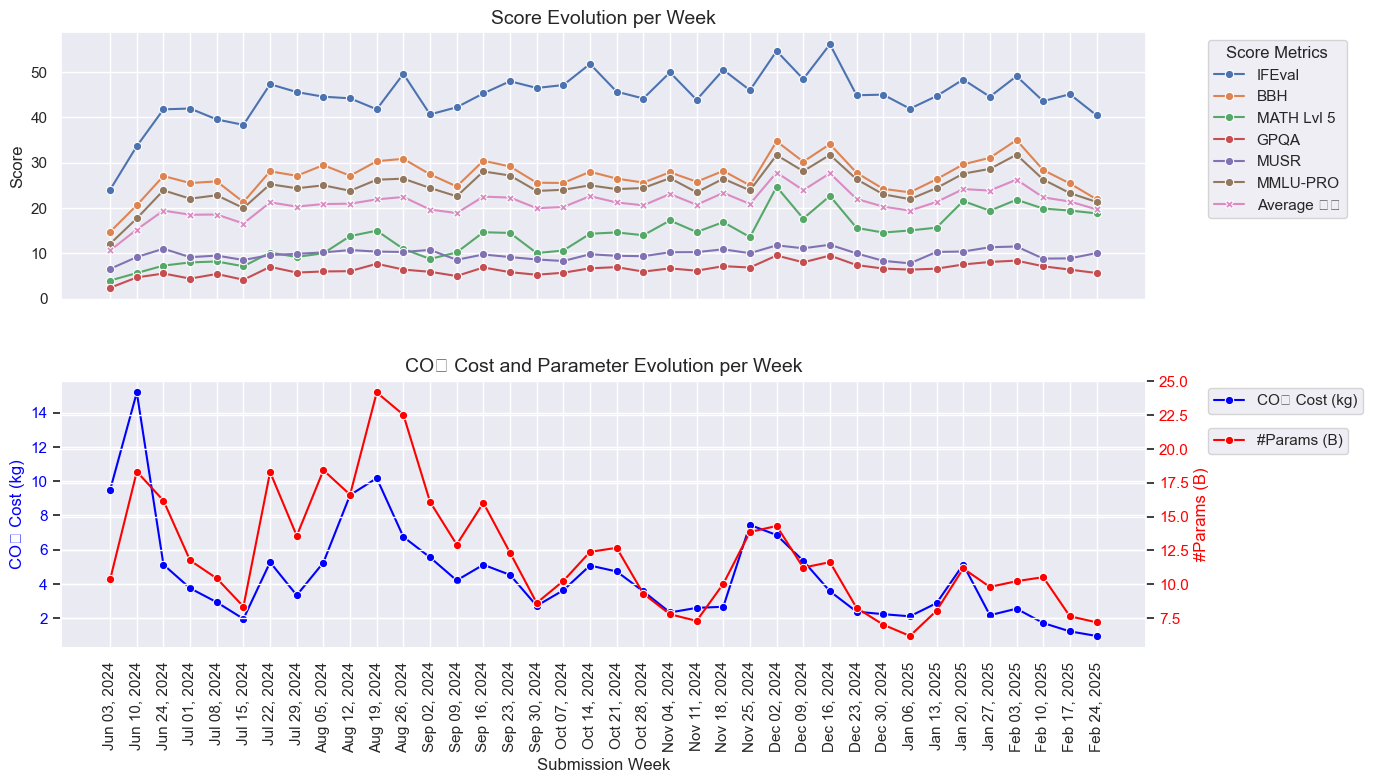

In [101]:
# Define score metrics
score_metrics = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO', 'Average ⬆️']

# Group by 'Submission Week' and calculate mean scores
weekly_avg = df.groupby(['Submission Week', 'Formatted Week'])[score_metrics].mean().reset_index()

# Sort by 'Submission Week' for temporal order
weekly_avg = weekly_avg.sort_values('Submission Week')

# Group by 'Submission Week' and calculate mean CO2 cost
weekly_co2 = df.groupby(['Submission Week', 'Formatted Week'])['CO₂ cost (kg)'].mean().reset_index()

# Sort by 'Submission Week' for temporal order
weekly_co2 = weekly_co2.sort_values('Submission Week')

# Calculate percentage change
weekly_co2['CO2 Cost % Change'] = weekly_co2['CO₂ cost (kg)'].pct_change() * 100

# Group by 'Submission Week' and calculate mean #Params (B)
weekly_params = df.groupby(['Submission Week', 'Formatted Week'])['#Params (B)'].mean().reset_index()

# Sort by 'Submission Week' for temporal order
weekly_params = weekly_params.sort_values('Submission Week')

# Create a figure with two subplots sharing the x-axis
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'hspace': 0.3})

# --- First panel: Score Evolution ---
for metric in score_metrics:
    mark = 'X' if metric == 'Average ⬆️' else 'o'
    sns.lineplot(ax=axes[0], x='Formatted Week', y=metric, data=weekly_avg, label=metric, marker=mark)

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Score Evolution per Week', fontsize=14)
axes[0].legend(title='Score Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True)

# --- Second panel: CO2 Cost and Parameter Evolution ---
ax1 = axes[1]  # Left y-axis (CO2 cost)
ax2 = ax1.twinx()  # Right y-axis (Params)

sns.lineplot(ax=ax1, x='Formatted Week', y='CO₂ cost (kg)', data=weekly_co2, marker='o', color='blue', label='CO₂ Cost (kg)')
sns.lineplot(ax=ax2, x='Formatted Week', y='#Params (B)', data=weekly_params, marker='o', color='red', label='#Params (B)')

ax1.set_ylabel('CO₂ Cost (kg)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)
ax1.set_title('CO₂ Cost and Parameter Evolution per Week', fontsize=14)
ax1.tick_params(axis='x', rotation=90)

ax2.set_ylabel('#Params (B)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adjust the legend for both axes in the second panel to avoid overlap
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=True)
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.85), frameon=True)

# X-axis settings (shared)
axes[1].set_xlabel('Submission Week', fontsize=12)

# Adjust layout
plt.show()

# Top Architecture Extraction

In [102]:
# Group by 'Architecture Type' and count the number of submissions
architecture_submission_count = df['Architecture'].value_counts().reset_index()

# Rename the columns for clarity
architecture_submission_count.columns = ['Architecture', 'Submission Count']

# Sort by submission count to get top architectures (for example, top 5)
top_architectures = architecture_submission_count.sort_values('Submission Count', ascending=False).head(5)

# Filter the original dataframe to include only the top architectures
top_architectures_df = df[df['Architecture'].isin(top_architectures['Architecture'])]

top_architectures_df = top_architectures_df.sort_values('Submission Date')

# Top Architecture - Submission Count Trend

Monthly

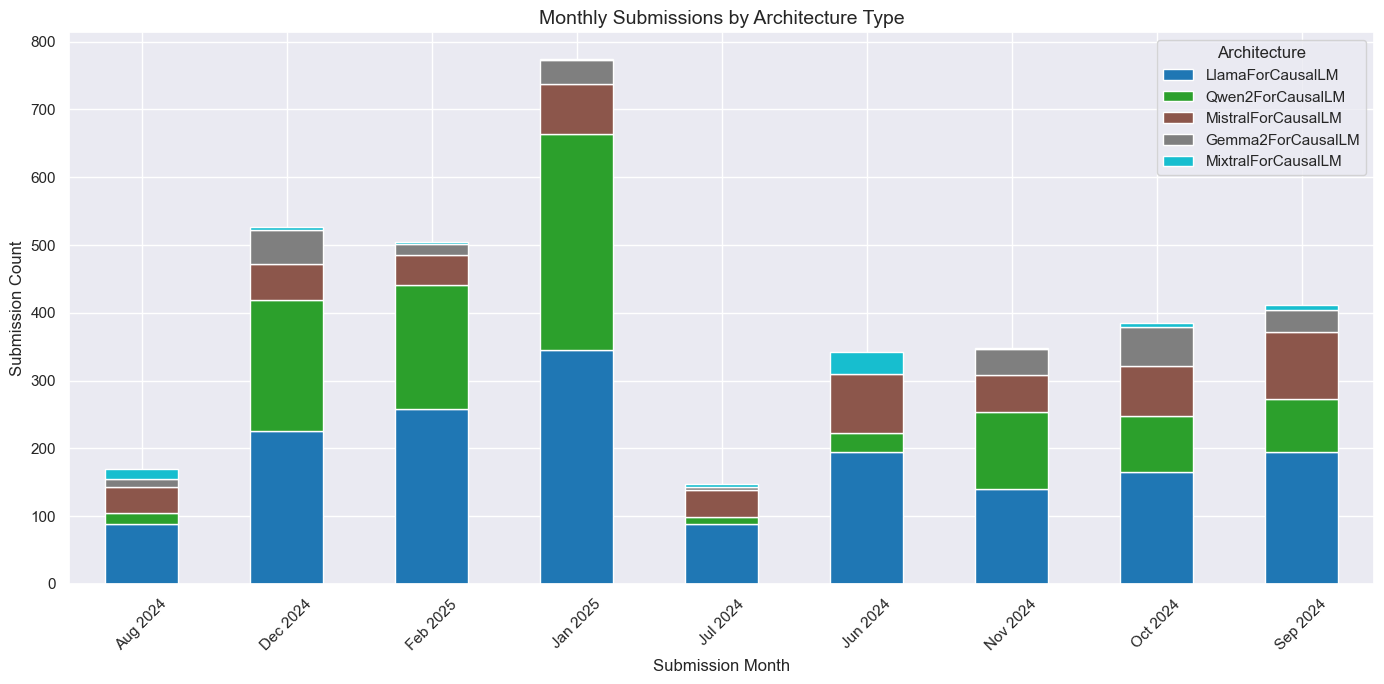

In [103]:
# Group by 'Submission Month', 'Formatted Month', and 'Architecture' and count the submissions
monthly_architecture_submission = df.groupby(['Submission Month', 'Formatted Month', 'Architecture']).size().reset_index(name='Submission Count')

# Filter to include only top architectures from the previously calculated top_architectures_df
monthly_architecture_submission = monthly_architecture_submission[monthly_architecture_submission['Architecture'].isin(top_architectures_df['Architecture'])]

# Ensure temporal sorting before pivoting
monthly_architecture_submission = monthly_architecture_submission.sort_values(by='Submission Month')

# Pivot the data to create a table with 'Submission Month' as index and 'Architecture' as columns
pivot_df = monthly_architecture_submission.pivot_table(index=['Submission Month', 'Formatted Month'],
                                                        columns='Architecture', values='Submission Count',
                                                        aggfunc='sum', fill_value=0)

# Sort columns based on the sum of submissions
pivot_df = pivot_df.loc[:, pivot_df.sum(axis=0).sort_values(ascending=False).index]

# Set index to 'Formatted Month' for proper labeling
pivot_df.index = pivot_df.index.get_level_values('Formatted Month')

# Create the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab10')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Submission Month', fontsize=12)
plt.ylabel('Submission Count', fontsize=12)
plt.title('Monthly Submissions by Architecture Type', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


# Top Architecture - Parameter Trend

Monthly

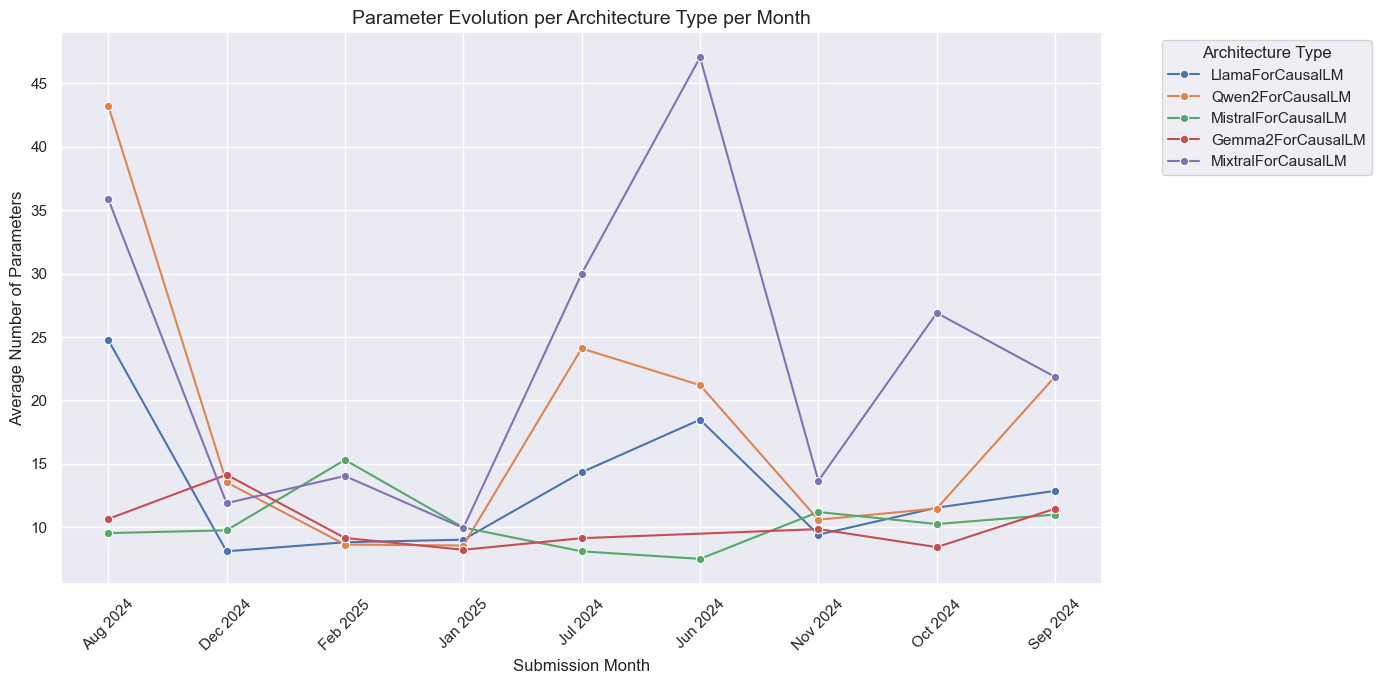

In [104]:
# Group by 'Submission Month', 'Formatted Month', and 'Architecture Type' and calculate mean for '#Params (B)'
monthly_param_avg = top_architectures_df.groupby(['Submission Month', 'Formatted Month', 'Architecture'])['#Params (B)'].mean().reset_index()

# Sort by 'Submission Month' for proper temporal order
monthly_param_avg = monthly_param_avg.sort_values('Submission Month')

# Count the total submissions for each architecture type
architecture_submission_count = top_architectures_df.groupby('Architecture').size().reset_index(name='Submission Count')

# Sort the architectures by submission count in descending order
sorted_architectures = architecture_submission_count.sort_values('Submission Count', ascending=False)['Architecture'].tolist()

# Create the plot
plt.figure(figsize=(14, 7))

# Plot each architecture type's parameter evolution, ensuring the legend is sorted by submission count
for arch in sorted_architectures:
    arch_data = monthly_param_avg[monthly_param_avg['Architecture'] == arch]
    sns.lineplot(x='Formatted Month', y='#Params (B)', data=arch_data, label=arch, marker='o')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Submission Month', fontsize=12)
plt.ylabel('Average Number of Parameters', fontsize=12)
plt.title('Parameter Evolution per Architecture Type per Month', fontsize=14)

# Adjust legend placement
plt.legend(title='Architecture Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Weekly

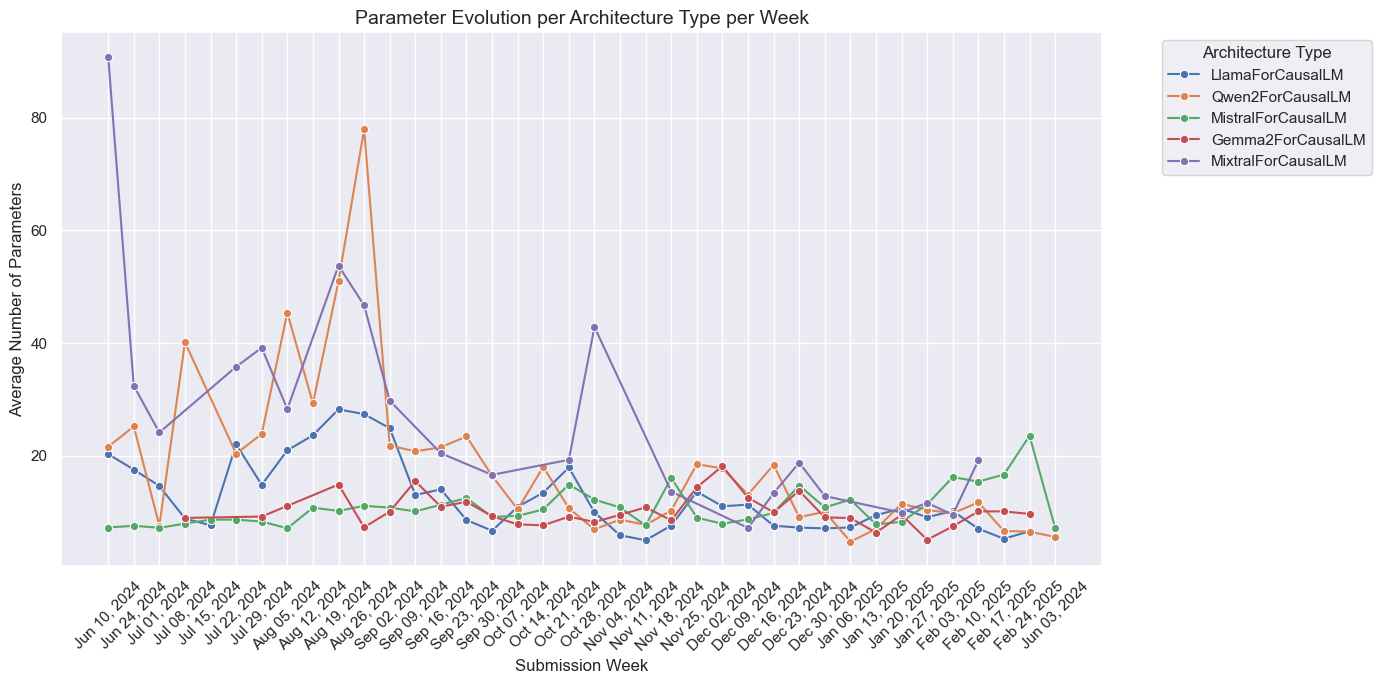

In [105]:
# Group by 'Submission Week', 'Formatted Week', and 'Architecture Type' and calculate mean for '#Params (B)'
weekly_param_avg = top_architectures_df.groupby(['Submission Week', 'Formatted Week', 'Architecture'])['#Params (B)'].mean().reset_index()

# Sort by 'Submission Week' for temporal order
weekly_param_avg = weekly_param_avg.sort_values('Submission Week')

# Count the total submissions for each architecture type
architecture_submission_count_week = top_architectures_df.groupby('Architecture').size().reset_index(name='Submission Count')

# Sort the architectures by submission count in descending order
sorted_architectures_week = architecture_submission_count_week.sort_values('Submission Count', ascending=False)['Architecture'].tolist()

# Create the plot
plt.figure(figsize=(14, 7))

# Plot each architecture type's parameter evolution for the week, ensuring the legend is sorted by submission count
for arch in sorted_architectures_week:
    arch_data_week = weekly_param_avg[weekly_param_avg['Architecture'] == arch]
    sns.lineplot(x='Formatted Week', y='#Params (B)', data=arch_data_week, label=arch, marker='o')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Submission Week', fontsize=12)
plt.ylabel('Average Number of Parameters', fontsize=12)
plt.title('Parameter Evolution per Architecture Type per Week', fontsize=14)

# Adjust legend placement
plt.legend(title='Architecture Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Top Architecture - CO2 Trend

Monthly

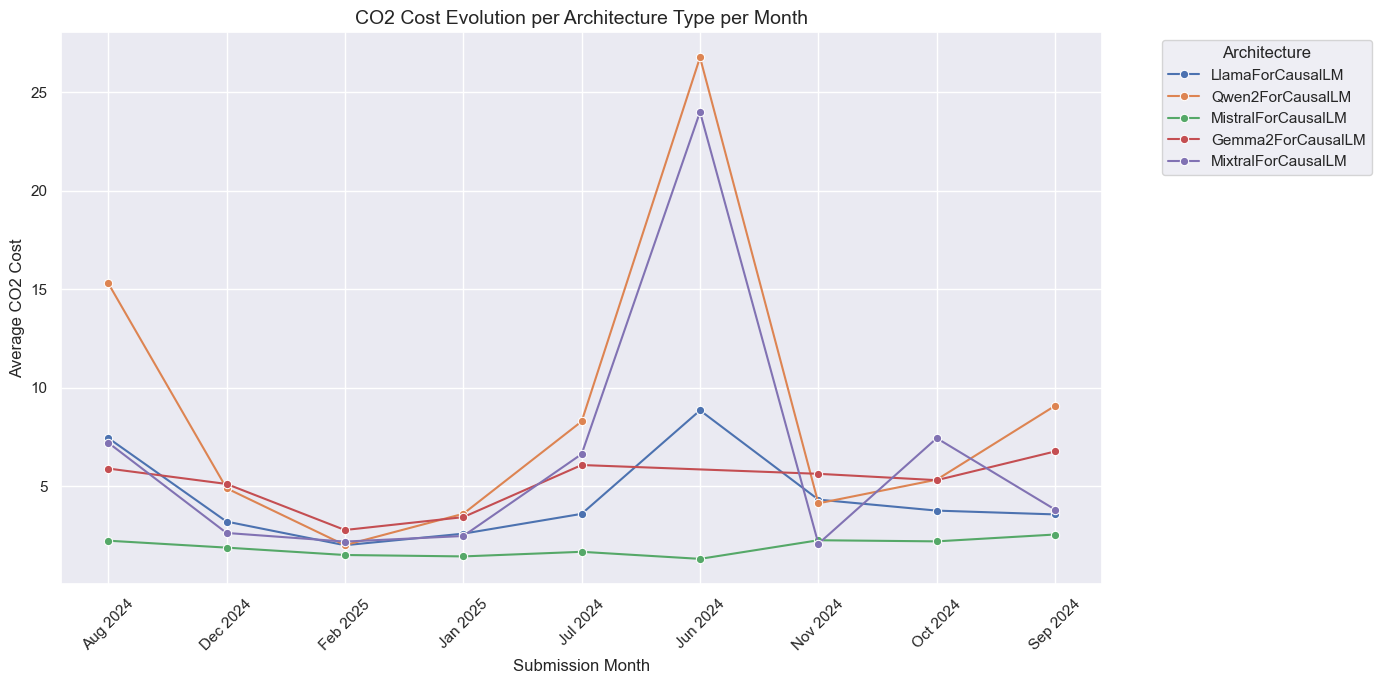

In [106]:
# Group by 'Submission Month', 'Formatted Month', and 'Architecture' and calculate mean for 'CO2 Cost'
monthly_co2_avg = top_architectures_df.groupby(['Submission Month', 'Formatted Month', 'Architecture'])['CO₂ cost (kg)'].mean().reset_index()

# Sort by 'Submission Month' for temporal order
monthly_co2_avg = monthly_co2_avg.sort_values('Submission Month')

# Count the total submissions for each architecture
architecture_submission_count_month = top_architectures_df.groupby('Architecture').size().reset_index(name='Submission Count')

# Sort the architectures by submission count in descending order
sorted_architectures_month = architecture_submission_count_month.sort_values('Submission Count', ascending=False)['Architecture'].tolist()

# Create the plot
plt.figure(figsize=(14, 7))

# Plot each architecture type's CO2 cost evolution for the month, ensuring the legend is sorted by submission count
for arch in sorted_architectures_month:
    arch_data_month = monthly_co2_avg[monthly_co2_avg['Architecture'] == arch]
    sns.lineplot(x='Formatted Month', y='CO₂ cost (kg)', data=arch_data_month, label=arch, marker='o')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Add labels and title
plt.xlabel('Submission Month', fontsize=12)
plt.ylabel('Average CO2 Cost', fontsize=12)
plt.title('CO2 Cost Evolution per Architecture Type per Month', fontsize=14)
# Adjust legend placement
plt.legend(title='Architecture', bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

Weekly

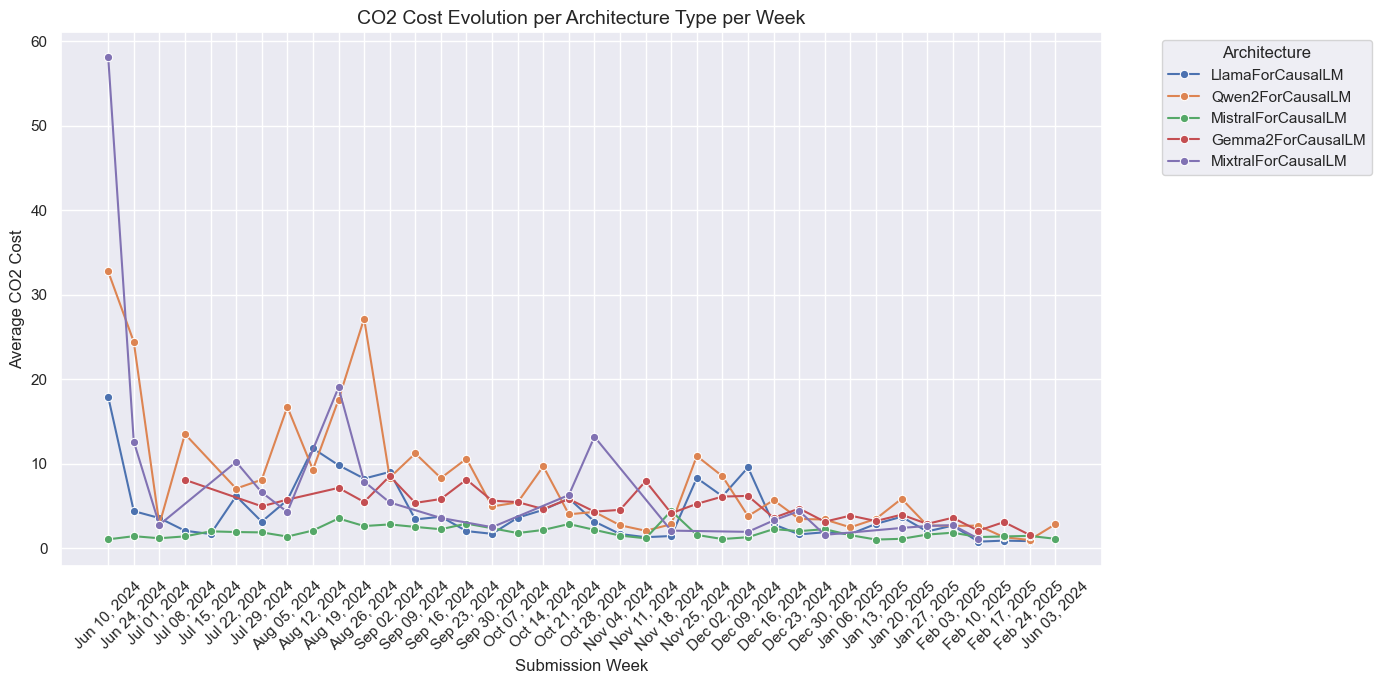

In [107]:
# Group by 'Submission Week', 'Formatted Week', and 'Architecture' and calculate mean for 'CO2 Cost'
weekly_co2_avg = top_architectures_df.groupby(['Submission Week', 'Formatted Week', 'Architecture'])['CO₂ cost (kg)'].mean().reset_index()

# Sort by 'Submission Week' for temporal order
weekly_co2_avg = weekly_co2_avg.sort_values('Submission Week')

# Count the total submissions for each architecture
architecture_submission_count_week = top_architectures_df.groupby('Architecture').size().reset_index(name='Submission Count')

# Sort the architectures by submission count in descending order
sorted_architectures_week = architecture_submission_count_week.sort_values('Submission Count', ascending=False)['Architecture'].tolist()

# Create the plot
plt.figure(figsize=(14, 7))

# Plot each architecture type's CO2 cost evolution for the week, ensuring the legend is sorted by submission count
for arch in sorted_architectures_week:
    arch_data_week = weekly_co2_avg[weekly_co2_avg['Architecture'] == arch]
    sns.lineplot(x='Formatted Week', y='CO₂ cost (kg)', data=arch_data_week, label=arch, marker='o')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Submission Week', fontsize=12)
plt.ylabel('Average CO2 Cost', fontsize=12)
plt.title('CO2 Cost Evolution per Architecture Type per Week', fontsize=14)

# Adjust legend placement
plt.legend(title='Architecture', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Top Architecutre - Param and CO2 Trend

Two panel plot - Monthly

/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yifan/dev/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


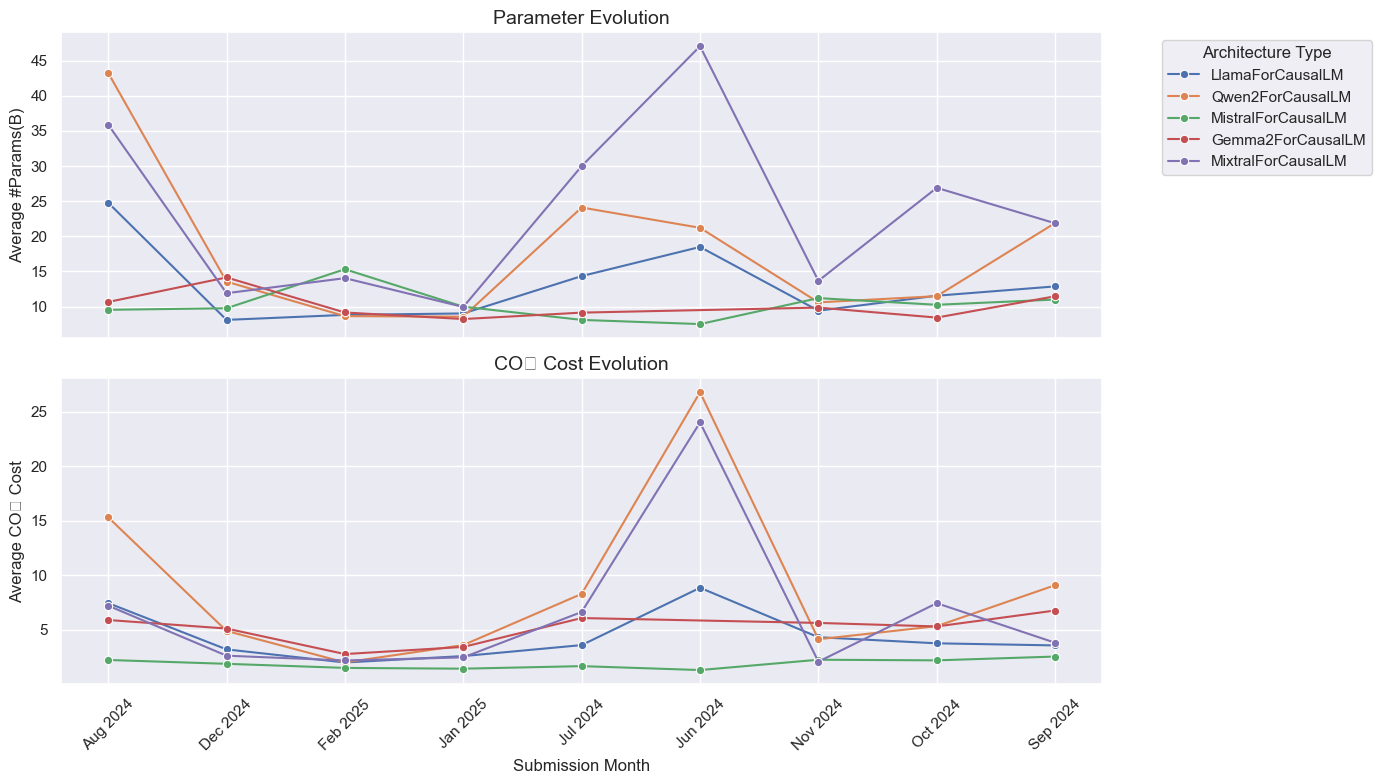

In [108]:
# Group by 'Submission Month', 'Formatted Month', and 'Architecture' and calculate mean for '#Params (B)'
monthly_param_avg = top_architectures_df.groupby(['Submission Month', 'Formatted Month', 'Architecture'])['#Params (B)'].mean().reset_index()

# Group by 'Submission Month', 'Formatted Month', and 'Architecture' and calculate mean for 'CO₂ Cost'
monthly_co2_avg = top_architectures_df.groupby(['Submission Month', 'Formatted Month', 'Architecture'])['CO₂ cost (kg)'].mean().reset_index()

# Sort by 'Submission Month' for proper temporal order
monthly_param_avg = monthly_param_avg.sort_values('Submission Month')
monthly_co2_avg = monthly_co2_avg.sort_values('Submission Month')

# Count the total submissions for each architecture
architecture_submission_count = top_architectures_df.groupby('Architecture').size().reset_index(name='Submission Count')

# Sort the architectures by submission count in descending order
sorted_architectures = architecture_submission_count.sort_values('Submission Count', ascending=False)['Architecture'].tolist()

# Create a shared x-axis plot with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot Parameter Evolution
for arch in sorted_architectures:
    arch_data = monthly_param_avg[monthly_param_avg['Architecture'] == arch]
    sns.lineplot(ax=axes[0], x='Formatted Month', y='#Params (B)', data=arch_data, label=arch, marker='o')

axes[0].set_ylabel('Average #Params(B)', fontsize=12)
axes[0].set_title('Parameter Evolution', fontsize=14)
axes[0].legend(title='Architecture Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot CO₂ Cost Evolution
for arch in sorted_architectures:
    arch_data_co2 = monthly_co2_avg[monthly_co2_avg['Architecture'] == arch]
    sns.lineplot(ax=axes[1], x='Formatted Month', y='CO₂ cost (kg)', data=arch_data_co2, marker='o')

axes[1].set_xlabel('Submission Month', fontsize=12)
axes[1].set_ylabel('Average CO₂ Cost', fontsize=12)
axes[1].set_title('CO₂ Cost Evolution', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Top Architecture - Efficiency Trend

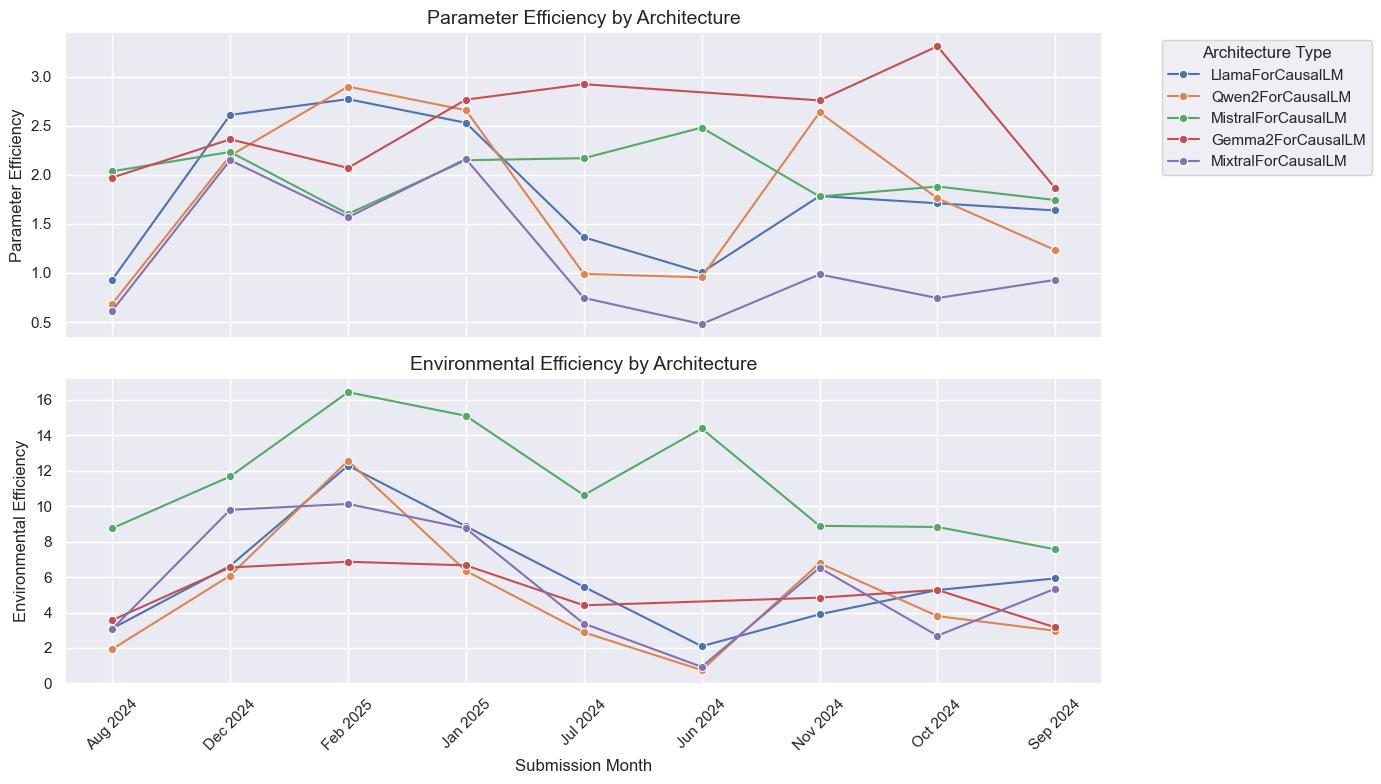

In [109]:
# Compute mean for '#Params (B)', 'CO₂ cost (kg)', and 'Average ⬆️' per architecture per month
monthly_avg = top_architectures_df.groupby(['Submission Month', 'Formatted Month', 'Architecture'])[
    ['#Params (B)', 'CO₂ cost (kg)', 'Average ⬆️']
].mean().reset_index()

# Compute efficiency metrics
monthly_avg['Parameter Efficiency'] = monthly_avg['Average ⬆️'] / monthly_avg['#Params (B)']
monthly_avg['Environmental Efficiency'] = monthly_avg['Average ⬆️'] / monthly_avg['CO₂ cost (kg)']

# Sort by 'Submission Month' for proper temporal order
monthly_avg = monthly_avg.sort_values('Submission Month')

# Count the total submissions for each architecture
architecture_submission_count = top_architectures_df.groupby('Architecture').size().reset_index(name='Submission Count')

# Sort the architectures by submission count in descending order
sorted_architectures = architecture_submission_count.sort_values('Submission Count', ascending=False)['Architecture'].tolist()

# Create a shared x-axis plot with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot Parameter Efficiency Evolution
for arch in sorted_architectures:
    arch_data = monthly_avg[monthly_avg['Architecture'] == arch]
    sns.lineplot(ax=axes[0], x='Formatted Month', y='Parameter Efficiency', data=arch_data, label=arch, marker='o')

axes[0].set_ylabel('Parameter Efficiency', fontsize=12)
axes[0].set_title('Parameter Efficiency by Architecture', fontsize=14)
axes[0].legend(title='Architecture Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot Environmental Efficiency Evolution
for arch in sorted_architectures:
    arch_data_co2 = monthly_avg[monthly_avg['Architecture'] == arch]
    sns.lineplot(ax=axes[1], x='Formatted Month', y='Environmental Efficiency', data=arch_data_co2, marker='o')

axes[1].set_xlabel('Submission Month', fontsize=12)
axes[1].set_ylabel('Environmental Efficiency', fontsize=12)
axes[1].set_title('Environmental Efficiency by Architecture', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()